# This pipeline runs spatial analysis for 10X visium data
## Prepare pipeline environment
To run this pipline, we recommend to use the docker contianer. That page describes how to run the pipeline using docker. If you are using HPC, then it's recommended to run this pipeline using singularity. You can download the docker image using singularity with the command: <br/> 
> **singularity pull docker://shl198/sc_ppl:202306**. <br/>

Singularity image file is not writable, you can transfer it to a sandbox and then you will be able to install packages inside it without administrator role. The commands are:
> singularity build --sandbox sc_pipeline/ sc_ppl.sif <br/>
> singularity run -w sc_pipeline jupyter-lab --no-browser --port 8887

In the end, you can open jupyter-lab by copying and pasting the url shown in terminal.

# 0. Load packages

In [1]:
import scanpy as sc
import anndata as ad
import squidpy as sq
import scanorama
import math

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from bioinfokit import visuz

import numpy as np
import pandas as pd
import glob
import os

import warnings
warnings.filterwarnings("ignore")

import stlearn as st

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

2023-05-04 16:06:56.717493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 16:06:56.862929: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/R/lib/:/hpc/grid/lsfhpcprod/10.1/linux3.10-glibc2.17-x86_64/lib:/.singularity.d/libs:/hpc/grid/lsfhpcprod/10.1/linux3.10-glibc2.17-x86_64/lib:/.singularity.d/libs
2023-05-04 16:06:56.862956: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-04 16:06:58.648551: W tensorflow/compile

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8
squidpy==1.2.3


In [3]:
import importlib
import utils.visium_modules as vis
importlib.reload(vis)

<module 'utils.visium_modules' from '/home/lis262/Code/scRNASeq_spatial/spatial_pipeline/utils/visium_modules.py'>

# 1. Preprocessing
## 1.1 Load data

In [ ]:
path = '/media/hpc/grid/wip_drm_targetsciences/projects/p051_senescence_esf'
work_path = f'{path}/p01_visium_20220819/Analysis'
raw_path = f'{work_path}/f01_raw'
file_pres = [f for f in sorted(glob.glob(f'{raw_path}/*')) if os.path.isdir(f)]

sasp_gene_fn = f'{path}/senecense_SASP.txt'
sasp_genes = pd.read_csv(sasp_gene_fn,header=None)[0].to_list()
senmyo_gene_fn = f'{path}/senmyo.txt'
senmyo_genes = pd.read_csv(senmyo_gene_fn,header=None)[0].to_list()
fibro_gene_fn = f'{path}/fibro_genes.txt'
fibro_genes = pd.read_csv(fibro_gene_fn,header=None)[0].to_list()

In [4]:
adata_list, samples = vis.get_adata_list(file_pres)

In [16]:
# genes = adata_list[0].var.index.tolist()

# fn = '/lustre/scratch/lis262/visium_v2_gene.tsv'
# df = pd.read_csv(fn, sep=',', header=0, index_col=0)
# genes2 = df.index.tolist()

# inter = set(genes).intersection(genes2)

# print(len(genes), len(genes2), len(inter))

17943 18050 17338


## 1.2 Plot QC plots
Distribution of total_counts, distribution of n_genes_by_counts(The number of genes with at least 1 count in a cell)

In [ ]:
for sp, ad in zip(samples, adata_list):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(f"QC: {sp}")
    sns.histplot(ad.obs["total_counts"], kde=False, ax=axs[0])
    sns.histplot(ad.obs["n_genes_by_counts"], kde=False, ax=axs[1])
    # axs[0].set_ylim(0,350)
    # axs[1].set_ylim(0,350)
    # sns.histplot(ad.obs["n_genes_by_counts"][ad.obs["n_genes_by_counts"]<1000], kde=False, ax=axs[3])

## 1.3 Normalize each sample separately

In [5]:
vis.norm_hv_gene(adata_list)

# 2. Analyze one sample first

## 2.1 Clustering

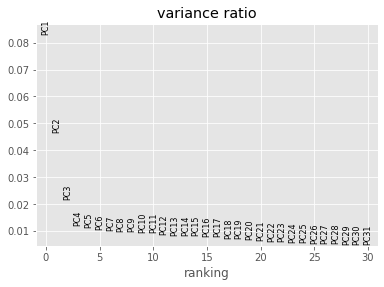

In [61]:
sc.pp.pca(ann_sp, svd_solver='arpack')
sc.pl.pca_variance_ratio(ann_sp)

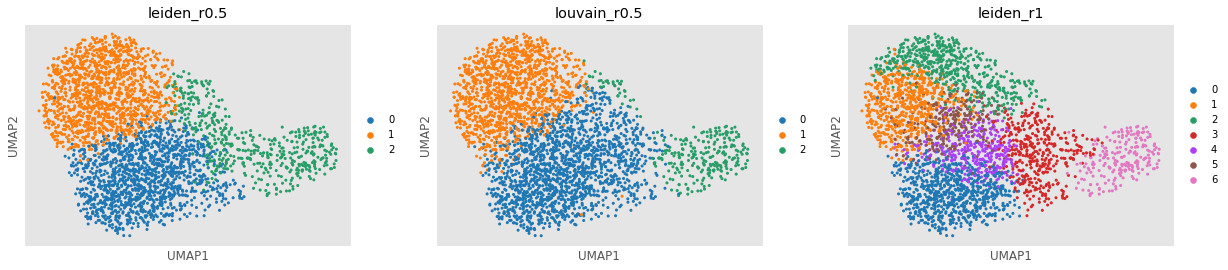

In [17]:
# cluster using umap and leiden
sc.pp.pca(ann_sp, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(ann_sp)
sc.tl.umap(ann_sp)
sc.tl.leiden(ann_sp, key_added='leiden_r1',resolution=1)
sc.tl.leiden(ann_sp, key_added='leiden_r0.5',resolution=0.5)
sc.tl.louvain(ann_sp, key_added='louvain_r0.5',resolution=0.5)
sc.pl.umap(ann_sp, color=['leiden_r0.5','louvain_r0.5','leiden_r1'], palette=sc.pl.palettes.default_20)

# 2 Integrate data clustering

## 2.1 Integrate data using scanorama

In [6]:
# adata_list = adata_list[2:5] + adata_list[0:2]
adatas_cor = scanorama.correct_scanpy(adata_list, return_dimred=True)

Found 11076 genes among all datasets
[[0.         0.33147632 0.1810585  0.         0.         0.
  0.         0.10027855 0.00278552 0.        ]
 [0.         0.         0.43609023 0.0075188  0.0112782  0.0075188
  0.         0.01879699 0.0075188  0.        ]
 [0.         0.         0.         0.010279   0.01076848 0.47185512
  0.00342633 0.00636319 0.00538424 0.00783162]
 [0.         0.         0.         0.         0.84048507 0.00593472
  0.01733577 0.00589067 0.00996264 0.        ]
 [0.         0.         0.         0.         0.         0.0164346
  0.26246959 0.02214892 0.01867995 0.0096393 ]
 [0.         0.         0.         0.         0.         0.
  0.02159367 0.00094251 0.01214197 0.49528068]
 [0.         0.         0.         0.         0.         0.
  0.         0.00447691 0.00973236 0.04957421]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.49657534 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.  

In [7]:
adata_spatial = sc.concat(adatas_cor, label="library_id", uns_merge="unique",
    keys=[k for d in [ad.uns['spatial'] for ad in adatas_cor] for k, v in d.items()], index_unique="-",)
adata_spatial.raw = adata_spatial

In [8]:
adata_spatial.obs['sample'].value_counts()

nash           4381
sample_C1      4244
sample_D       4026
sample_B       3288
fibrosis_A1    3271
fibrosis_B1    3216
sample_C2      3212
biopsy_1459    2043
biopsy_1306     359
biopsy_1443     266
Name: sample, dtype: int64

## 2.2 Clustering and UMAP
Using leiden method on scanorama embeddings

In [9]:
sc.pp.neighbors(adata_spatial, use_rep="X_scanorama")
sc.tl.umap(adata_spatial)
sc.tl.leiden(adata_spatial, key_added="clusters", resolution=1)

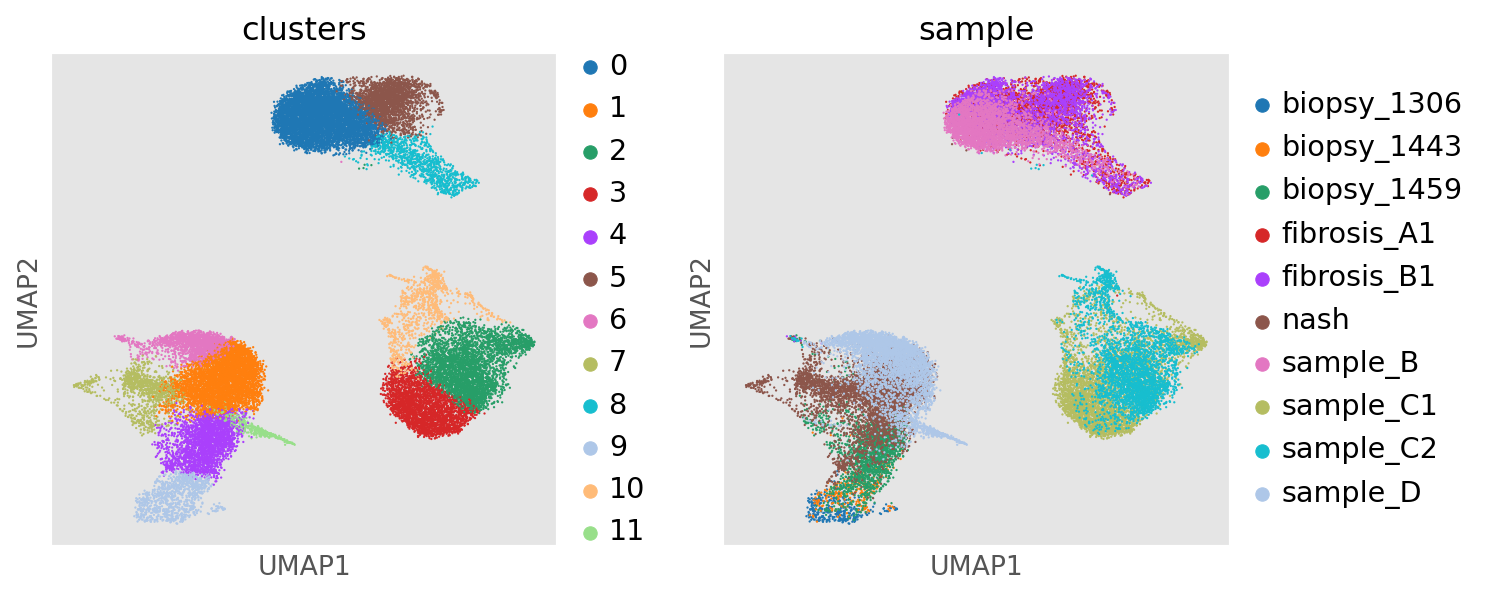

In [21]:
sc.set_figure_params()
plt.style.use('ggplot')
sc.pl.umap(adata_spatial, color=["clusters", "sample"], palette=sc.pl.palettes.default_20)

In [11]:
clusters_colors = dict(zip([str(i) for i in range(18)], adata_spatial.uns["clusters_colors"]))

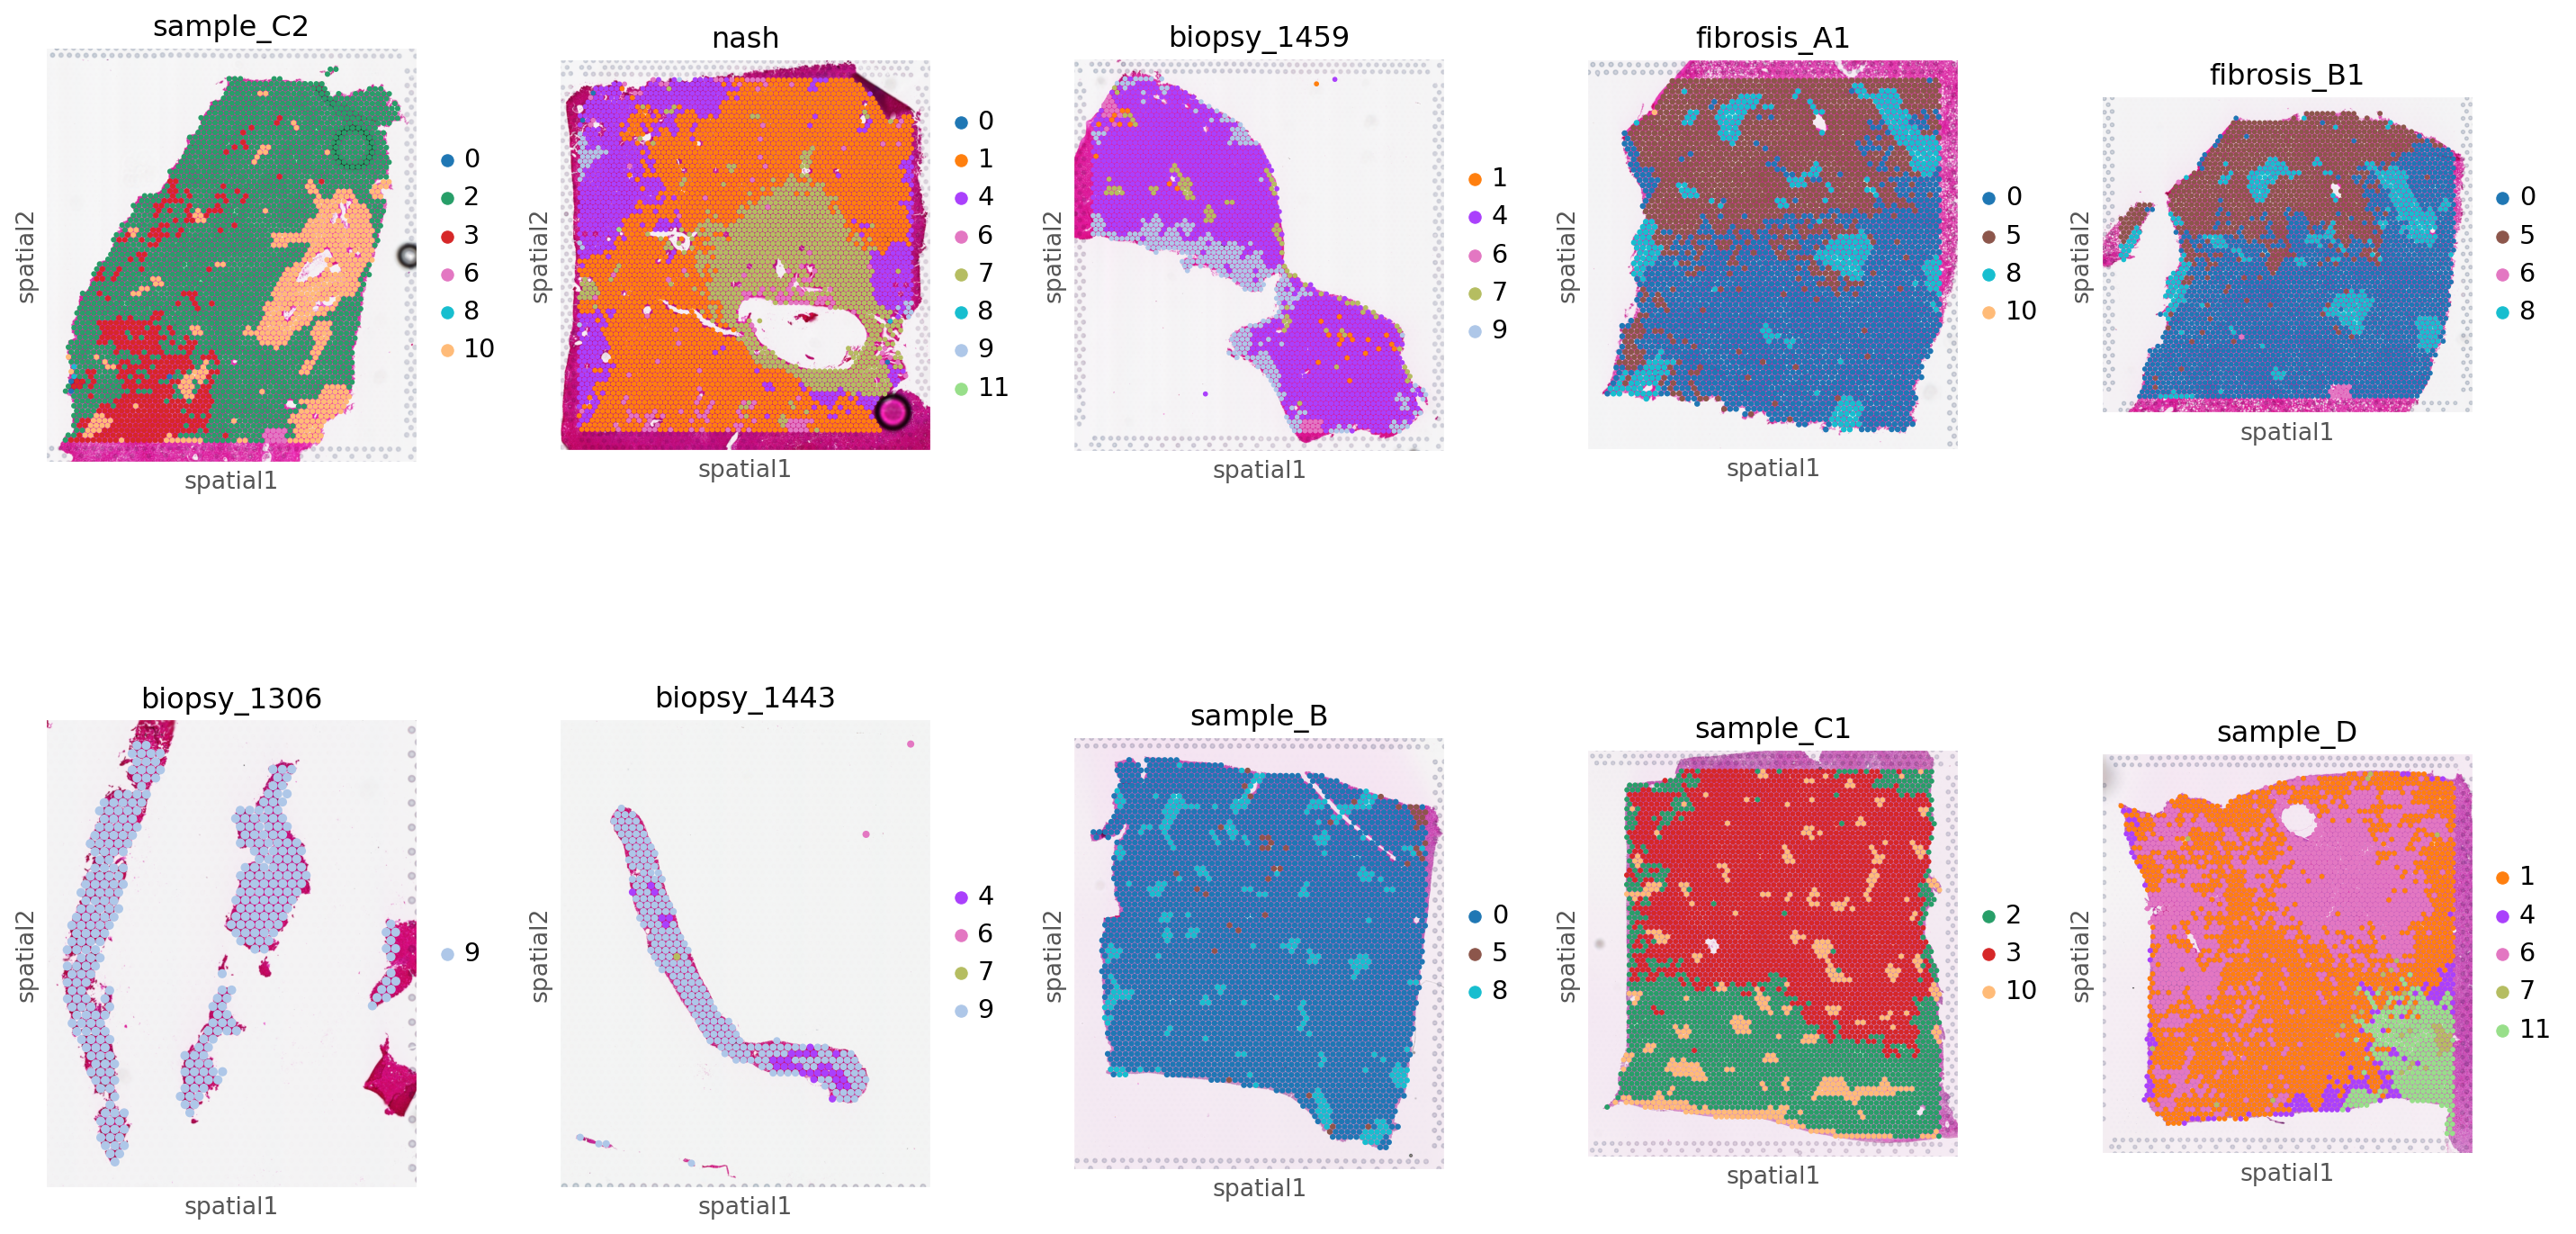

In [20]:
ncol = 5
fig, axs = plt.subplots(math.ceil(len(adatas_cor)/ncol), ncol, figsize=(18, 10))
lib_sp_dict = adata_spatial.obs.set_index('library_id')['sample'].to_dict()
for i, library in enumerate(adata_spatial.uns['spatial'].keys()):
    col = i % ncol
    row = i // ncol
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    sc.pl.spatial(ad, img_key="hires", library_id=library, color="clusters", size=1.5, title=lib_sp_dict[library],
                  palette=[v for k, v in clusters_colors.items() if k in ad.obs.clusters.unique().tolist()],
        show=False, ax=axs[row, col])
plt.tight_layout()

In [22]:
print('number of cell in each cluster')
adata_spatial.obs['clusters'].value_counts()

number of cell in each cluster


0     6491
1     4555
2     3714
3     2774
4     2531
5     2244
6     1641
7     1070
8     1035
9      990
10     952
11     309
Name: clusters, dtype: int64

In [23]:
sc.tl.rank_genes_groups(adata_spatial, groupby='clusters')

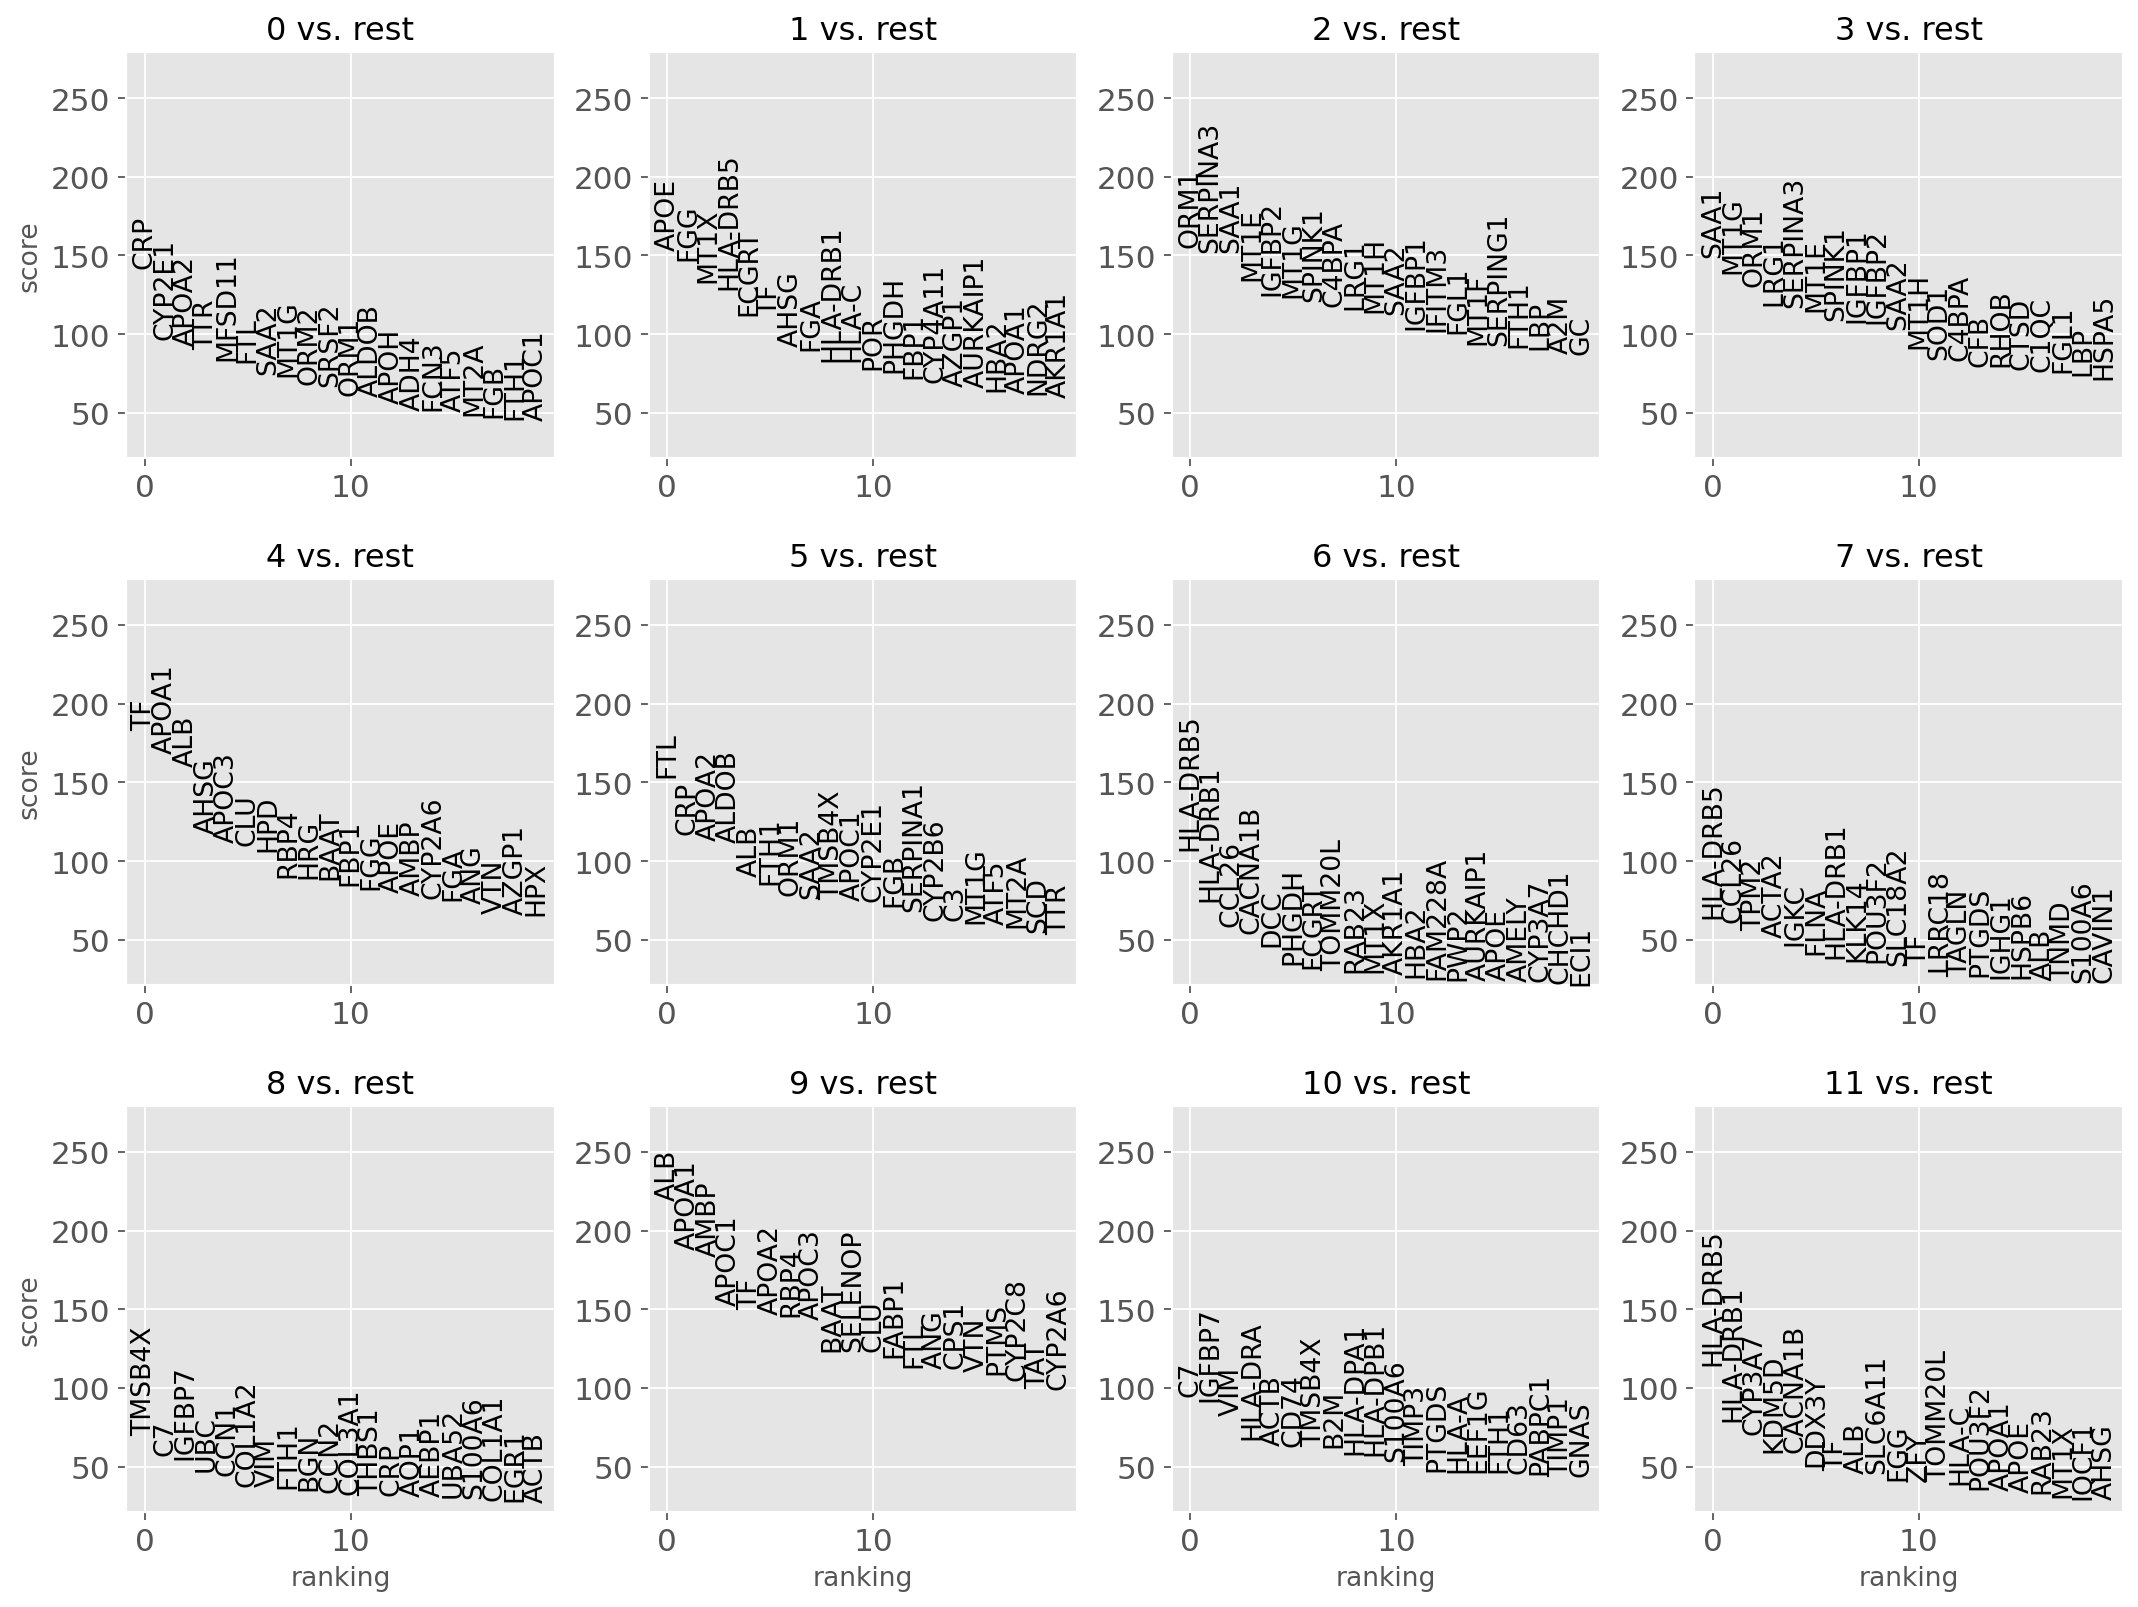

In [506]:
sc.pl.rank_genes_groups(adata_spatial, fontsize=12)

## 2.3 Determine fibrotic levels for clusters

In [24]:
# check fibrotic genes for each cluster
fibro_genes = list(set(fibro_genes).intersection(adata_spatial.var.index.tolist()))
sc.tl.dendrogram(adata_spatial, groupby='clusters', use_rep='X_scanorama')
adata_spatial.layers['scaled'] =  sc.pp.scale(adata_spatial.X)

In [25]:
fibro_adata = adata_spatial[:,fibro_genes].copy()
sc.tl.dendrogram(fibro_adata, groupby='clusters', use_rep='X_scanorama')

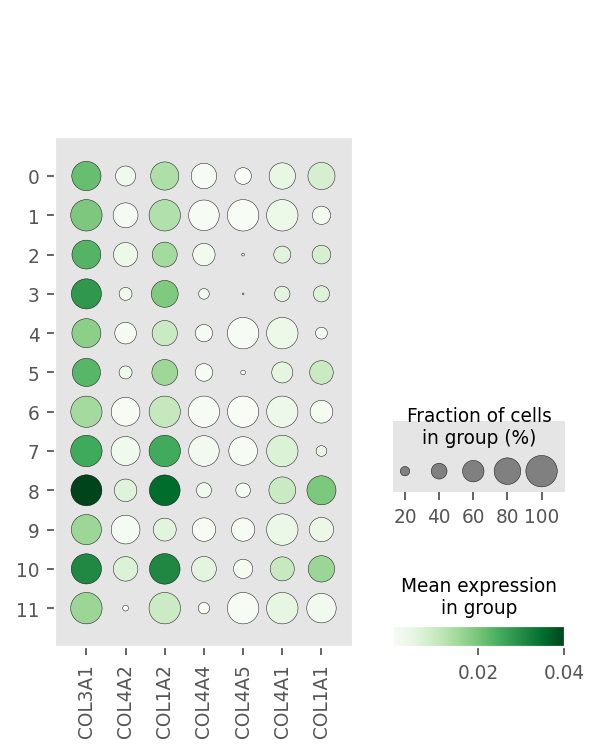

In [26]:
col_genes = [g for g in fibro_genes if g.startswith('COL')]
sc.pl.dotplot(fibro_adata,col_genes, 'clusters', cmap='Greens')

In [ ]:
sc.pl.dotplot(fibro_adata, fibro_genes, 'clusters', dendrogram=True, cmap='Greens')

In [ ]:
sc.pl.matrixplot(fibro_adata, fibro_genes, 'clusters', cmap='bwr', layer='scaled', colorbar_title='mean z-score', vmin=-2, vmax=2, dendrogram=True)

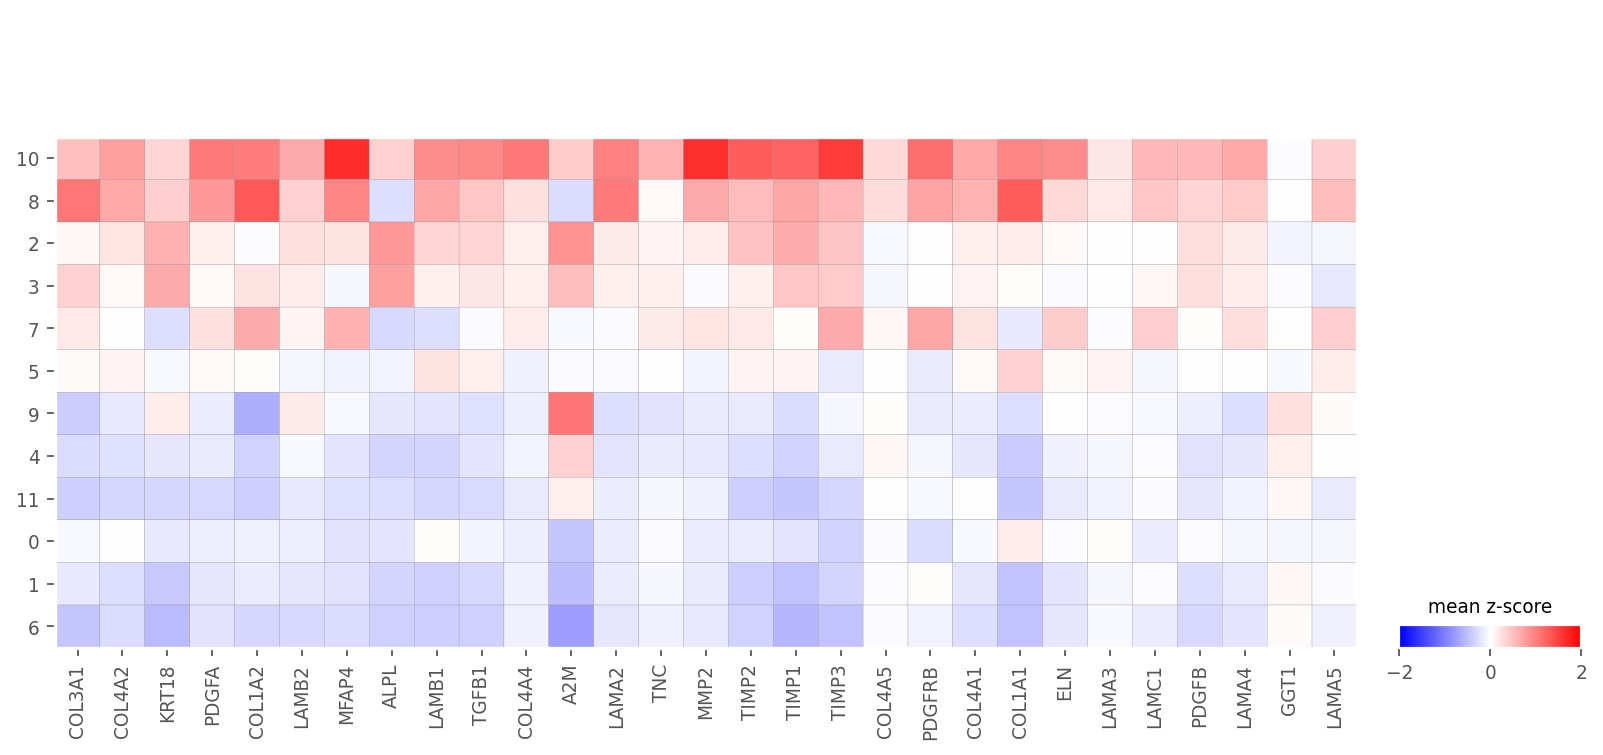

In [29]:
sc.pl.MatrixPlot.DEFAULT_COLOR_LEGEND_TITLE = 'mean z-score'
sc.pl.MatrixPlot.DEFAULT_COLORMAP= 'bwr'
sc.pl.MatrixPlot(fibro_adata, fibro_genes, 'clusters', layer='scaled', vmin=-2, vmax=2, categories_order=['10','8','2','3','7','5','9','4','11','0','1','6']).show()
sc.pl.MatrixPlot.DEFAULT_COLOR_LEGEND_TITLE= 'Mean expression\nin group'

In [ ]:
# plot sample separately
for sp in adata_spatial.obs['sample'].unique():
    ad = adata_spatial[adata_spatial.obs['sample'] == sp,:].copy()
    clusters = ad.obs['clusters'].unique().tolist()
    if len(clusters) > 1:
        sc.tl.dendrogram(ad, groupby='clusters', use_rep='X_scanorama')
        sc.pl.dotplot(ad, fibro_genes, 'clusters',title=sp, dendrogram=True)
    else:
        sc.pl.dotplot(ad, fibro_genes, 'clusters',title=sp)

In [ ]:
dp = sc.pl.dotplot(adata_spatial, fibro_genes, 'clusters', return_fig=True, dendrogram=True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

## 2.4 Check number of senescent cells in each cluster

In [30]:
def get_sene_spots(adata_list, genes, adata_spatial, label_col_name):
    # 1. get phenotype cells: senescence cells in this example
    all_sene_cells = []
    all_ring_cells = []
    all_norm_cells = []
    # genes = ['CDKN1A','GLB1', 'HMGB1']
    for ad in adata_list:
        sp = list(ad.uns['spatial'].keys())[0]
        sene_cells, ring_cells, norm_cells = vis.filter_spots_by_gene(ad,genes)
        all_sene_cells.extend([f'{c}-{sp}' for c in sene_cells])
        all_ring_cells.extend([f'{c}-{sp}' for c in ring_cells])
        all_norm_cells.extend([f'{c}-{sp}' for c in norm_cells])
    
    adata_spatial.obs[label_col_name] = 'other'
    adata_spatial.obs.loc[all_ring_cells,label_col_name] = 'ring'
    adata_spatial.obs.loc[all_sene_cells,label_col_name] = 'sene'
    
genes = ['CDKN1A','GLB1', 'HMGB1']
label_col_name = 'sene_cluster'
get_sene_spots(adata_list, genes, adata_spatial, label_col_name)

Text(0.5, 1.0, 'senescent cells distribution in each cluster')

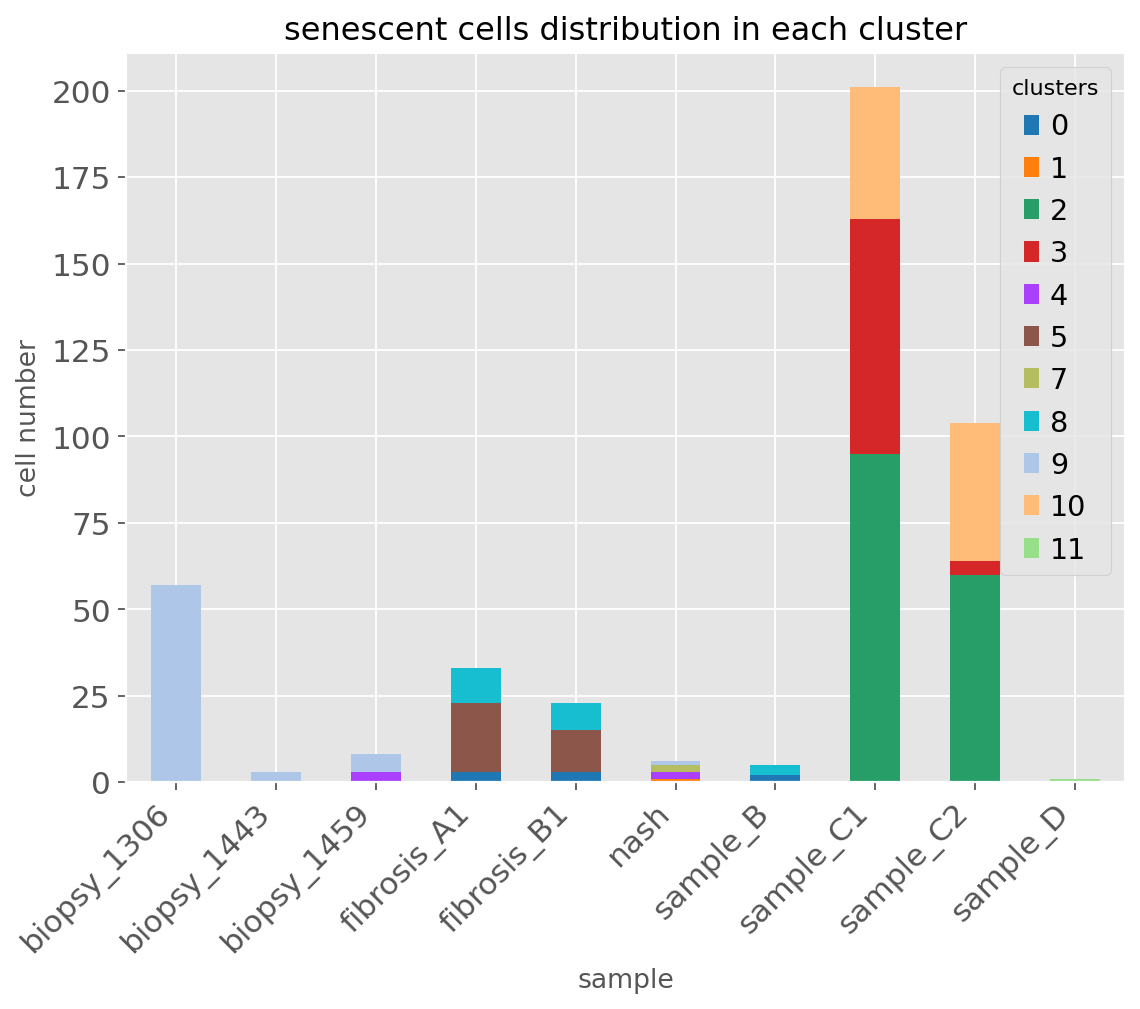

In [31]:
sene_cell_df = adata_spatial.obs.query('sene_cluster == "sene"').copy()
count_df = sene_cell_df[['sample','clusters']].value_counts().to_frame().reset_index()
count_df.rename(columns={0:'count'},inplace=True)
pivot_df = pd.pivot_table(data=count_df, index=['sample'], columns=['clusters'], values='count')
clusters_colors = dict(zip([str(i) for i in range(18)], adata_spatial.uns["clusters_colors"]))
ax = pivot_df.plot.bar(stacked=True, figsize=(8,6), rot=45, color=clusters_colors)
labels = ax.get_xticklabels()
_ = ax.set_xticklabels(labels, ha='right')
ax.set_ylabel('cell number')
ax.set_title('senescent cells distribution in each cluster')

In [32]:
adata_spatial.write(f'{work_path}/sene_adata.h5ad')

In [19]:
adata_spatial = sc.read_h5ad(f'{work_path}/sene_adata.h5ad')
adata_spatial.uns['log1p']['base'] = None

# 3 DE analysis

In [43]:
def de_genes_violin(adata_spatial, test_label, key, de_res_fn):
    ''' violin plot for significant genes
    * key: rank_gene_group key
    '''  
    
    all_sene_df = pd.read_csv(de_res_fn, sep='\t',header=0)
    all_sene_df, up_genes, dn_genes = vis.get_sig_de_genes(all_sene_df, test_label)

    print('number of up genes:',len(up_genes))
    print('number of down genes:',len(dn_genes))

    print('up genes overlap with sasp genes:', len(set(up_genes).intersection(sasp_genes)))
    print('dn genes overlap with sasp genes:', len(set(dn_genes).intersection(sasp_genes)))
    print('up genes overlap with senmyo genes:', len(set(up_genes).intersection(senmyo_genes)))
    print('dn genes overlap with senmyo genes:', len(set(dn_genes).intersection(senmyo_genes)))

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    plot_genes = all_sene_df[f'{test_label}_names'].tolist()[:20]
    sc.pl.rank_genes_groups_violin(adata_spatial, groups=test_label, gene_names=plot_genes, ax=axes[0], key=key, show=False, use_raw=True)

    plot_genes = all_sene_df.query(f'{test_label}_names in @sasp_genes')[f'{test_label}_names'].tolist()[:20]
    sc.pl.rank_genes_groups_violin(adata_spatial, groups=test_label, gene_names=plot_genes, ax=axes[1], key=key, show=False, use_raw=True)

## 3.1 sene in (8,10) VS normal in (0,1,6,11)
all senescent spots in high-fibrosis/steatosis clusters (8, 10) vs all of the normal cells in normal clusters (0, 1, 6, 11)

In [33]:
adata_spatial.X[adata_spatial.X < 0] = 0

In [34]:
def assign_group_more_sene_norrm(row):
    if row['sene_cluster'] == 'sene' and row['clusters'] in ['8','10']:
        return 'sene'
    elif row['sene_cluster'] == 'other' and row['clusters'] in ['0','1','6','11']:
        return 'normal'
    else:
        return 'other'
adata_spatial.obs['group4de'] = adata_spatial.obs.apply(lambda row: assign_group_more_sene_norrm(row), axis=1)
de_key = 'more_sene_VS_norm'
sc.tl.rank_genes_groups(adata_spatial, 'group4de', reference='normal', method='wilcoxon', groups=['sene','normal'], pts=True, key_added=de_key, use_raw=False)
print(adata_spatial.obs['group4de'].value_counts())
# extract de results
more_sene_vs_norm_df = vis.get_rank_genes_de_res(adata_spatial, de_key)
# output to file
de_path = f'{work_path}/f02_de'
os.makedirs(de_path, exist_ok=True)
de_fn = f'{de_path}/more_sene_VS_norm.tsv'
more_sene_vs_norm_df.to_csv(de_fn, sep='\t',index=False)

other     15714
normal    12493
sene         99
Name: group4de, dtype: int64


number of up genes: 6406
number of down genes: 1542
up genes overlap with sasp genes: 18
dn genes overlap with sasp genes: 1
up genes overlap with senmyo genes: 59
dn genes overlap with senmyo genes: 8


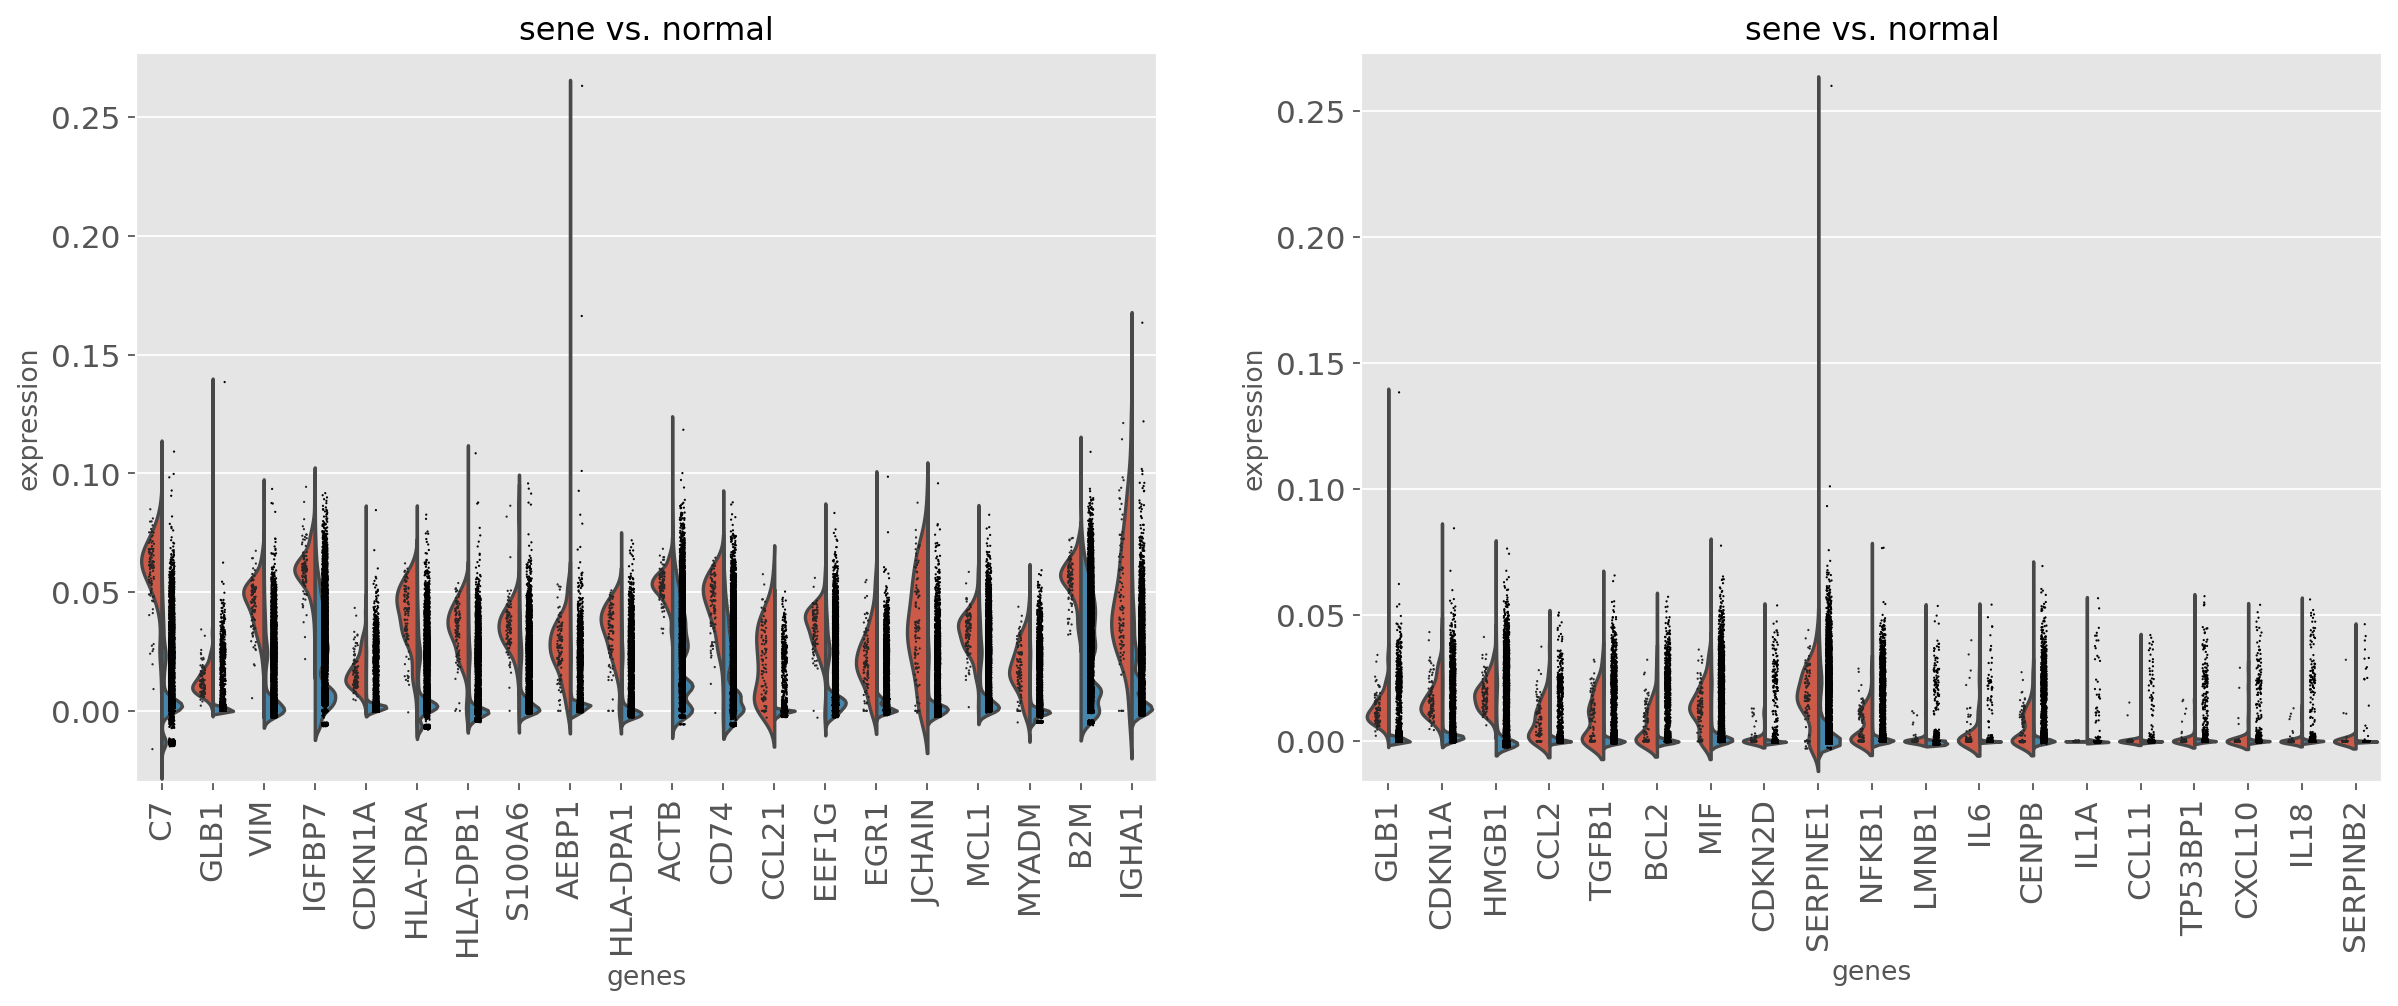

In [46]:
adata_spatial.obs['group4de'] = adata_spatial.obs.apply(lambda row: assign_group_more_sene_norrm(row), axis=1)
de_fn = f'{de_path}/more_sene_VS_norm.tsv'
de_genes_violin(adata_spatial, 'sene', 'more_sene_VS_norm', de_fn)

## 3.2 sene in (8,10) VS sene in normal (0,1,6, 11)
all senescent spots in high-fibrosis/steatosis clusters (8, 10) vs senescence spots in other clusters (0, 1, 6, 11)

In [36]:
def assign_group_more_sene_less_sene(row):
    if row['sene_cluster'] == 'sene' and row['clusters'] in ['8','10']:
        return 'sene'
    elif row['sene_cluster'] == 'sene' and row['clusters'] in ['0','1','6','11']:
        return 'sene_in_norm'
    else:
        return 'other'
adata_spatial.obs['group4de'] = adata_spatial.obs.apply(lambda row: assign_group_more_sene_less_sene(row), axis=1)
de_key = 'more_sene_VS_less_sene'
sc.tl.rank_genes_groups(adata_spatial, 'group4de', reference='sene_in_norm', method='wilcoxon', groups=['sene','sene_in_norm'], pts=True, key_added=de_key, use_raw=False)
print(adata_spatial.obs['group4de'].value_counts())
# extract de results
more_sene_vs_less_sene_df = vis.get_rank_genes_de_res(adata_spatial, de_key)
# output to file
de_path = f'{work_path}/f02_de'
os.makedirs(de_path, exist_ok=True)
de_fn = f'{de_path}/more_sene_VS_less_sene.tsv'
more_sene_vs_less_sene_df.to_csv(de_fn, sep='\t',index=False)

other           28197
sene               99
sene_in_norm       10
Name: group4de, dtype: int64


number of up genes: 120
number of down genes: 19
up genes overlap with sasp genes: 1
dn genes overlap with sasp genes: 0
up genes overlap with senmyo genes: 3
dn genes overlap with senmyo genes: 0


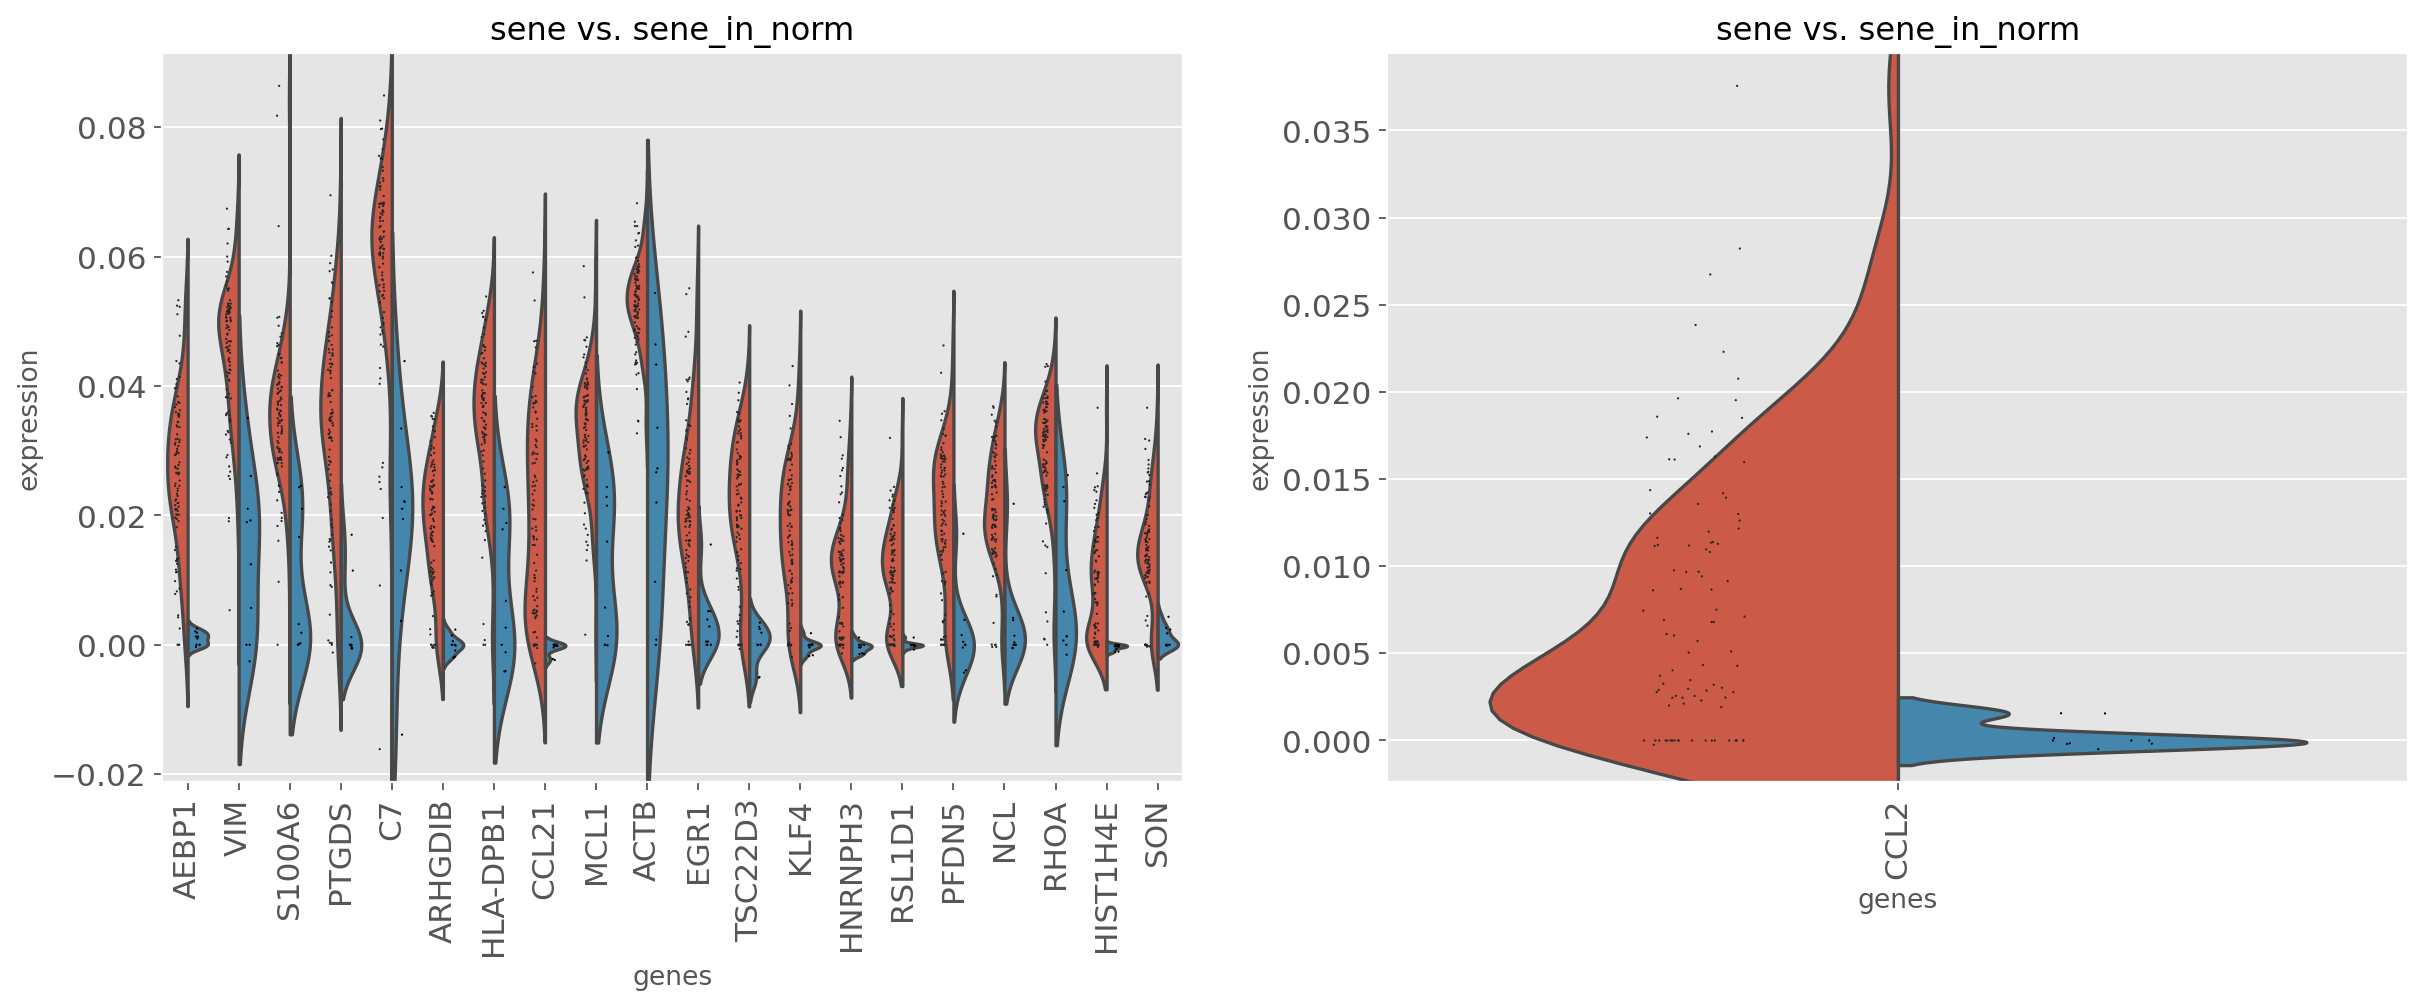

In [47]:
adata_spatial.obs['group4de'] = adata_spatial.obs.apply(lambda row: assign_group_more_sene_less_sene(row), axis=1)
de_fn = f'{de_path}/more_sene_VS_less_sene.tsv'
de_genes_violin(adata_spatial, 'sene', 'more_sene_VS_less_sene', de_fn)

## 3.3 all sene VS normal
all senescent spots in all clusters vs senescence spots in other clusters (0, 1, 6, 11)

In [37]:
def assign_group_all_sene_norm(row):
    if row['sene_cluster'] == 'sene':
        return 'sene'
    elif row['sene_cluster'] == 'other' and row['clusters'] in ['0','1','6','11']:
        return 'normal'
    else:
        return 'other'
adata_spatial.obs['group4de'] = adata_spatial.obs.apply(lambda row: assign_group_all_sene_norm(row), axis=1)
de_key = 'all_sene_VS_norm'
sc.tl.rank_genes_groups(adata_spatial, 'group4de', reference='normal', method='wilcoxon', groups=['sene','normal'], pts=True, key_added=de_key, use_raw=False)
print(adata_spatial.obs['group4de'].value_counts())
# extract de results
all_sene_vs_norm_df = vis.get_rank_genes_de_res(adata_spatial, de_key)
# output to file
de_path = f'{work_path}/f02_de'
os.makedirs(de_path, exist_ok=True)
de_fn = f'{de_path}/all_sene_VS_norm.tsv'
all_sene_vs_norm_df.to_csv(de_fn, sep='\t',index=False)

other     15372
normal    12493
sene        441
Name: group4de, dtype: int64


number of up genes: 5404
number of down genes: 1815
up genes overlap with sasp genes: 14
dn genes overlap with sasp genes: 2
up genes overlap with senmyo genes: 52
dn genes overlap with senmyo genes: 10


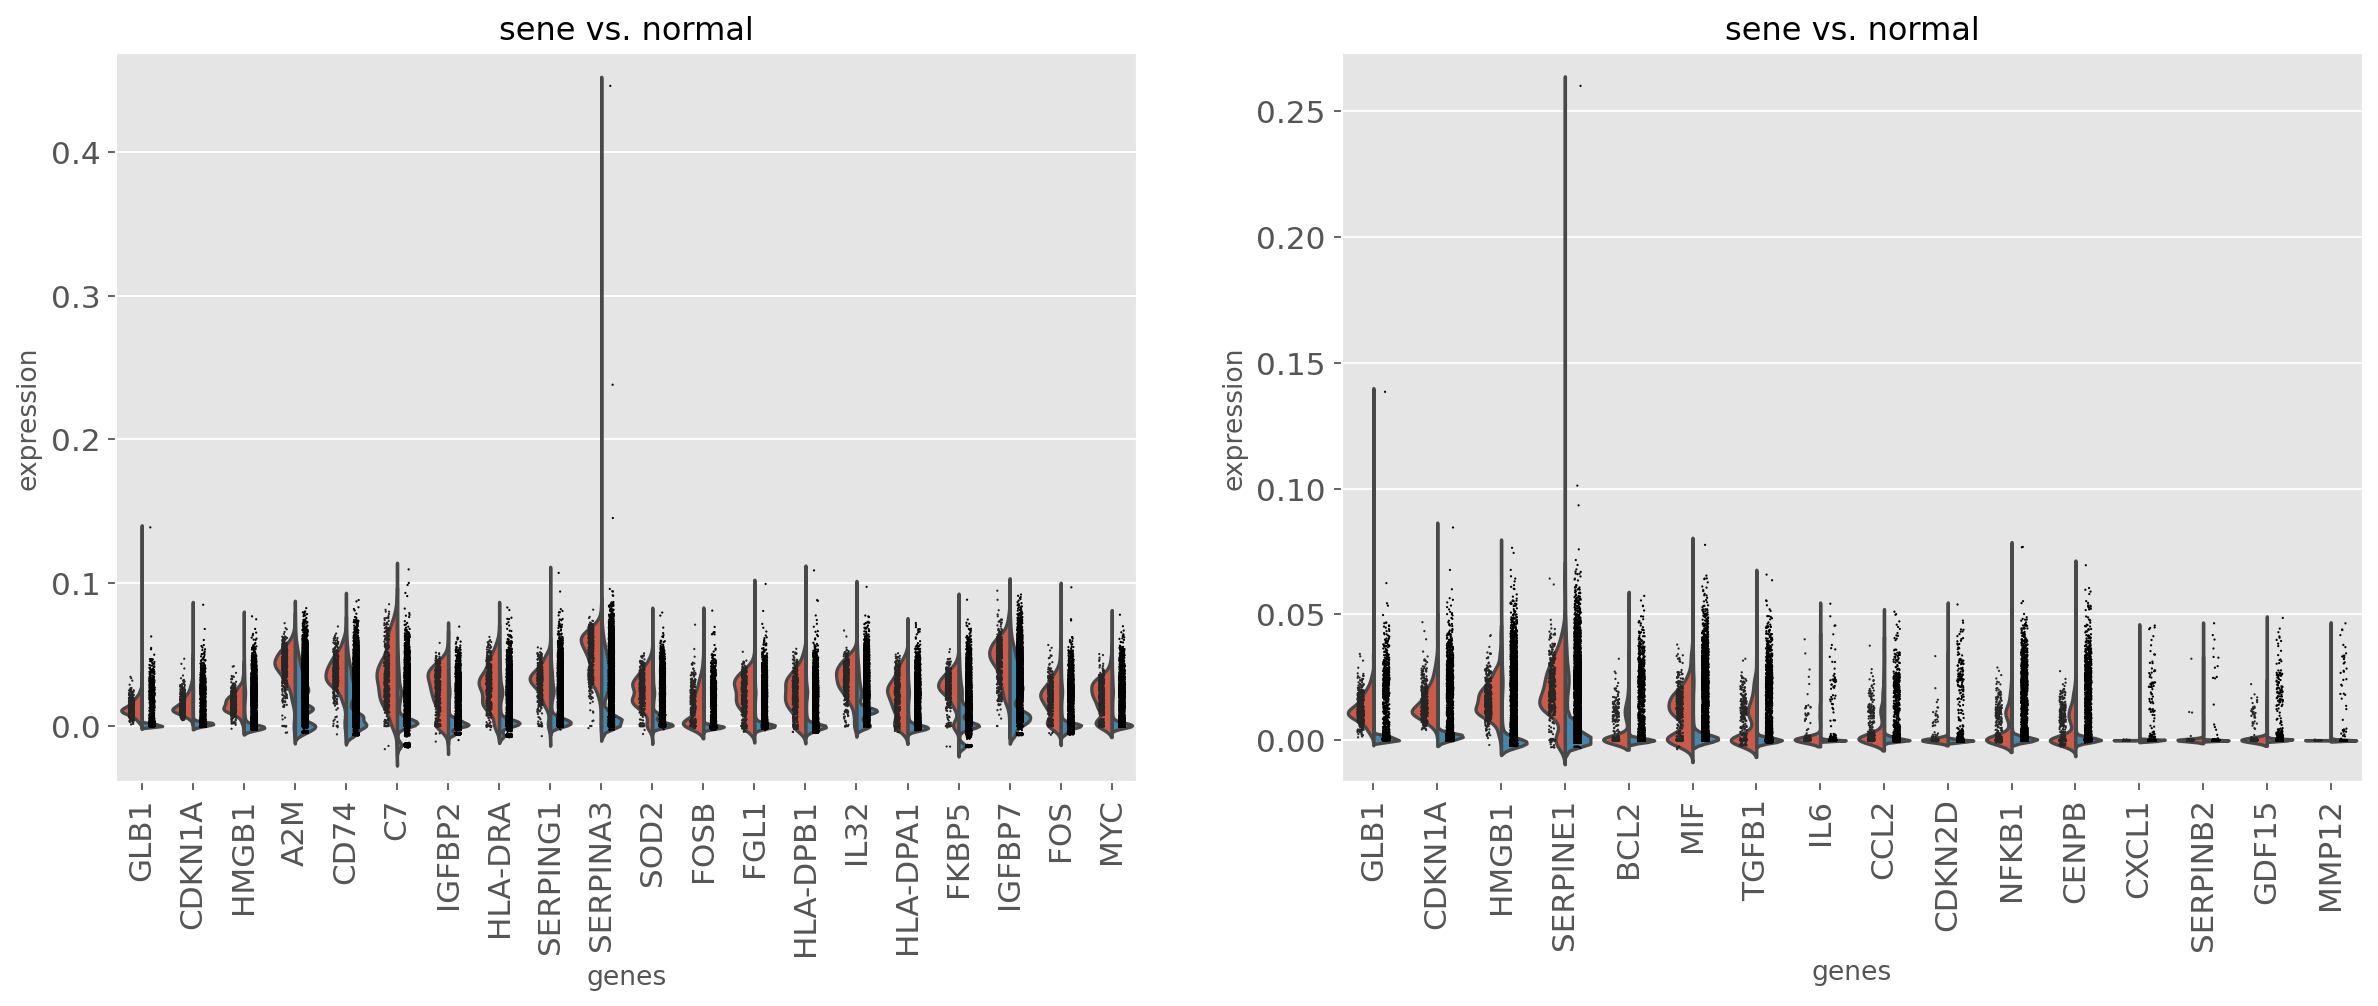

In [48]:
adata_spatial.obs['group4de'] = adata_spatial.obs.apply(lambda row: assign_group_all_sene_norm(row), axis=1)
de_fn = f'{de_path}/all_sene_VS_norm.tsv'
de_genes_violin(adata_spatial, 'sene', 'all_sene_VS_norm', de_fn)

## 3.4 all firbo clusters VS normal clusters
all fibrotic clusters (8, 10, 2, 3, 5, 7) VS normal clusters (0, 1, 6, 11)

In [38]:
def assign_group_fibro_norm(row):
    if row['clusters'] in ['8','10','2','3','5','7']:
        return 'fibro'
    elif row['clusters'] in ['0','1','6','11']:
        return 'normal'
    else:
        return 'other'
adata_spatial.obs['group4de'] = adata_spatial.obs.apply(lambda row: assign_group_fibro_norm(row), axis=1)
de_key = 'fibro_VS_norm'
sc.tl.rank_genes_groups(adata_spatial, 'group4de', reference='normal', method='wilcoxon', groups=['fibro','normal'], pts=True, key_added=de_key, use_raw=False)
print(adata_spatial.obs['group4de'].value_counts())
# extract de results
fibro_vs_norm_df = vis.get_rank_genes_de_res(adata_spatial, de_key)
# output to file
de_path = f'{work_path}/f02_de'
os.makedirs(de_path, exist_ok=True)
de_fn = f'{de_path}/fibro_VS_norm.tsv'
fibro_vs_norm_df.to_csv(de_fn, sep='\t',index=False)

normal    12996
fibro     11789
other      3521
Name: group4de, dtype: int64


number of up genes: 2949
number of down genes: 1781
up genes overlap with sasp genes: 7
dn genes overlap with sasp genes: 0
up genes overlap with senmyo genes: 32
dn genes overlap with senmyo genes: 7


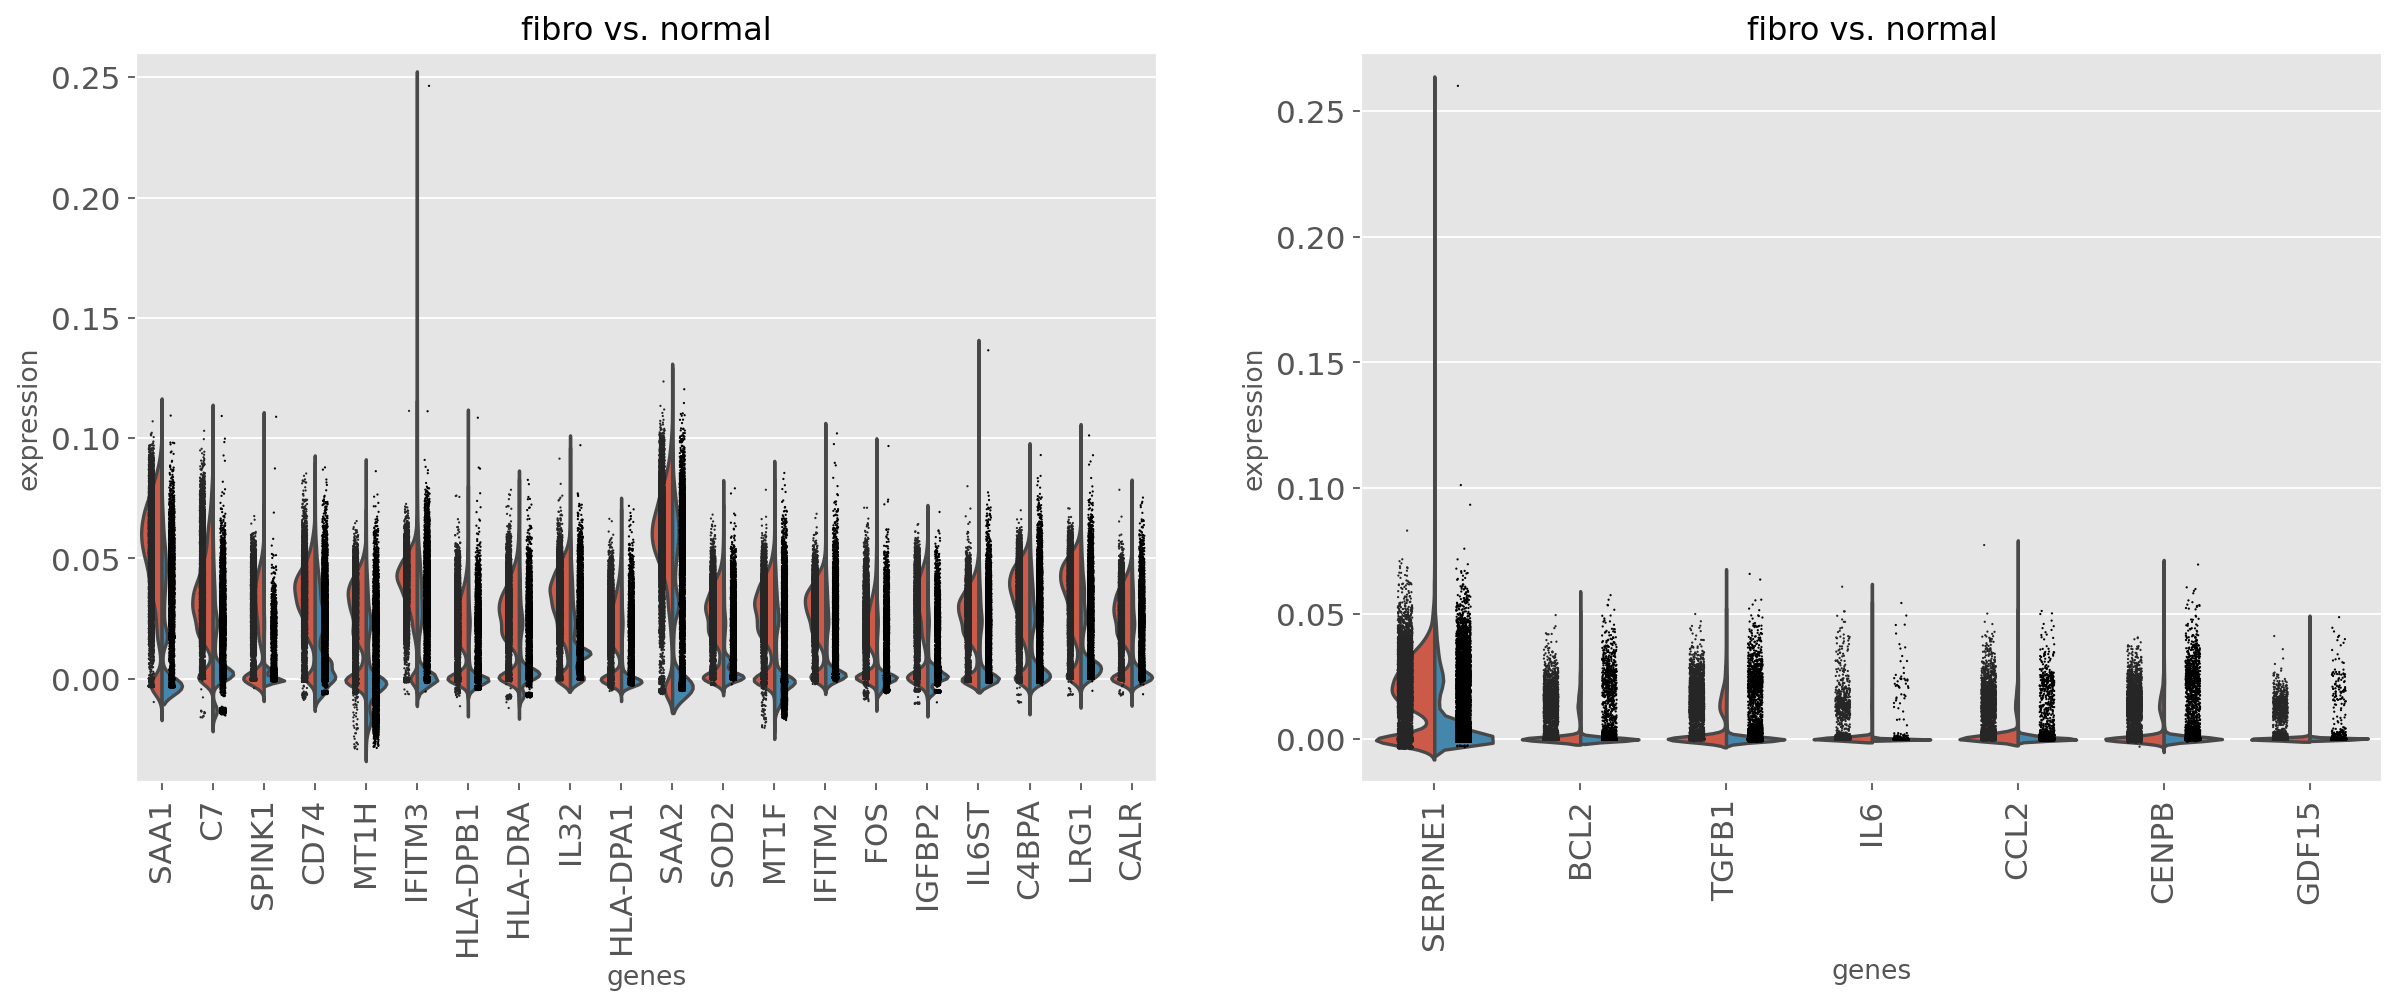

In [49]:
# plot violin plot for DE genes
adata_spatial.obs['group4de'] = adata_spatial.obs.apply(lambda row: assign_group_fibro_norm(row), axis=1)
de_fn = f'{de_path}/fibro_VS_norm.tsv'
de_genes_violin(adata_spatial, 'fibro', 'fibro_VS_norm', de_fn)

In [39]:
more_sene_vs_norm_df.head()

sene_names  sene_logfoldchanges  sene_scores    sene_pvals  sene_pvals_adj  \
0         C7             2.494088    16.173849  7.712658e-59    3.459706e-55   
1       GLB1             3.171509    16.093172  2.848609e-58    8.518765e-55   
2        VIM             2.268303    15.919606  4.632811e-57    1.187522e-53   
3     IGFBP7             1.416541    15.507274  3.097535e-54    5.557906e-51   
4     CDKN1A             2.426615    15.281886  1.009760e-52    1.647101e-49   

   pts_sene  pts_normal  
0  0.989899    0.837749  
1  1.000000    0.887777  
2  1.000000    0.755783  
3  1.000000    0.907388  
4  1.000000    0.811094

In [40]:
more_sene_vs_less_sene_df.head()

sene_names  sene_logfoldchanges  sene_scores    sene_pvals  sene_pvals_adj  \
0     IGFBP7             0.906944     4.944218  7.645021e-07        0.000852   
1      AEBP1             4.737387     4.933721  8.067787e-07        0.000852   
2        VIM             1.721973     4.881234  1.054240e-06        0.001051   
3     S100A6             1.976416     4.839245  1.303333e-06        0.001169   
4      PTGDS             3.526842     4.818251  1.448225e-06        0.001181   

   pts_sene  pts_sene_in_norm  
0  1.000000               1.0  
1  0.969697               0.6  
2  1.000000               0.7  
3  0.989899               0.8  
4  0.979798               0.3

In [41]:
all_sene_vs_norm_df.head()

sene_names  sene_logfoldchanges  sene_scores     sene_pvals  sene_pvals_adj  \
0       GLB1             3.171493    33.498116  5.133791e-246   9.211561e-242   
1     CDKN1A             2.245436    31.471798  2.112872e-217   1.895563e-213   
2      HMGB1             1.735120    25.397369  2.696424e-142   1.240563e-139   
3        A2M             1.156598    25.225353  2.111660e-140   8.891316e-138   
4       CD74             1.283566    24.791552  1.105775e-135   3.252610e-133   

   pts_sene  pts_normal  
0  1.000000    0.887777  
1  1.000000    0.811094  
2  0.997732    0.277996  
3  0.981859    0.795485  
4  0.986395    0.812695

In [42]:
fibro_vs_norm_df.head()

fibro_names  fibro_logfoldchanges  fibro_scores  fibro_pvals  \
0      IGFBP7              0.984300     86.469757          0.0   
1        SAA1              1.365634     83.998932          0.0   
2          C7              1.514954     79.496239          0.0   
3    SERPINA3              0.989043     79.372025          0.0   
4      SPINK1              3.058820     78.468285          0.0   

   fibro_pvals_adj  pts_fibro  pts_normal  
0              0.0   0.984986    0.907895  
1              0.0   0.898549    0.523777  
2              0.0   0.930613    0.836796  
3              0.0   0.986852    0.960526  
4              0.0   0.740860    0.329640

In [640]:
def DE_for_sene_vs_normal(genes, adata_list, adata_spatial, libraries, clusters, norm_cluster, test_label, label_col_name, de_key, de_res_fn):
    '''
    * genes: list of genes to define the phenotype
    * libraries: list of library ids to do DE analysis
    * cluster: list of clusters in sample that represent the phenotype cluster in each sample, should be the same length as samples
    * de_key: key added for rank_gene_group
    '''
    # 1. get phenotype cells: senescence cells in this example
    all_sene_cells = []
    all_ring_cells = []
    all_norm_cells = []
    # genes = ['CDKN1A','GLB1', 'HMGB1']
    for ad in adata_list:
        sp = list(ad.uns['spatial'].keys())[0]
        sene_cells, ring_cells, norm_cells = vis.filter_spots_by_gene(ad,genes)
        all_sene_cells.extend([f'{c}-{sp}' for c in sene_cells])
        all_ring_cells.extend([f'{c}-{sp}' for c in ring_cells])
        all_norm_cells.extend([f'{c}-{sp}' for c in norm_cells])

    print('nomral:', len(all_norm_cells), '\nring_cells:', len(all_ring_cells), '\nsene sells',len(all_sene_cells),'\n')
    
    # define senescence clusters that would be used as test in DE anlaysis
    sene_cells = []
    if  clusters == 'all':
        for lib in libraries:
            sub_cells = adata_spatial.obs.query('library_id == @lib').index.tolist()
            sene_cells.extend(list(set(sub_cells).intersection(all_sene_cells)))
    else:
        for lib, clust in zip(libraries, clusters):
            sub_cells = adata_spatial.obs.query('library_id == @lib and clusters in @clust').index.tolist()
            sene_cells.extend(list(set(sub_cells).intersection(all_sene_cells)))
    
    # define control clusters
    norm_cells = adata_spatial.obs.query('clusters in @norm_cluster').index.tolist()

    # add condition to adata_spatial
    adata_spatial.obs[label_col_name] = 'other'
    adata_spatial.obs.loc[norm_cells,label_col_name] = 'norm'
    adata_spatial.obs.loc[all_ring_cells,label_col_name] = 'ring'
    adata_spatial.obs.loc[sene_cells,label_col_name] = test_label
    print('number of cells in each condition\n',adata_spatial.obs[label_col_name].value_counts(),'\n')
    print('number of sene cells in each cluster\n', adata_spatial.obs.query('sene_cluster == "sene"')['clusters'].value_counts(),'\n')
    # DE analysis
    sc.tl.rank_genes_groups(adata_spatial, label_col_name, reference='norm', method='wilcoxon',groups=[test_label],pts=True,key_added=de_key)
    result = adata_spatial.uns[de_key]
    groups = result['names'].dtype.names
    de_df = pd.DataFrame({group + '_' + key: result[key][group] for group in groups for key in ['names', 'logfoldchanges','scores','pvals','pvals_adj']})
    pts_df = result['pts']
    pts_df.columns = ['pts_' + c for c in pts_df.columns]
    de_df = pd.merge(de_df, pts_df, how='left', left_on=f'{test_label}_names', right_index=True)
    de_df.to_csv(de_res_fn,sep='\t',index=False)
    return all_sene_cells, all_ring_cells, all_norm_cells

In [642]:
def de_genes_violin(adata_spatial, test_label, key, de_res_fn):
    ''' violin plot for significant genes
    * key: rank_gene_group key
    '''  
    
    all_sene_df = pd.read_csv(de_res_fn, sep='\t',header=0)
    all_sene_df, up_genes, dn_genes = vis.get_sig_de_genes(all_sene_df, test_label)

    print('number of up genes:',len(up_genes))
    print('number of down genes:',len(dn_genes))

    print('up genes overlap with sasp genes:', len(set(up_genes).intersection(sasp_genes)))
    print('dn genes overlap with sasp genes:', len(set(dn_genes).intersection(sasp_genes)))
    print('up genes overlap with senmyo genes:', len(set(up_genes).intersection(senmyo_genes)))
    print('dn genes overlap with senmyo genes:', len(set(dn_genes).intersection(senmyo_genes)))

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    plot_genes = all_sene_df[f'{test_label}_names'].tolist()[:20]
    sc.pl.rank_genes_groups_violin(adata_spatial, groups=test_label, gene_names=plot_genes, ax=axes[0], key=key, show=False)

    plot_genes = all_sene_df.query(f'{test_label}_names in @sasp_genes')[f'{test_label}_names'].tolist()[:20]
    sc.pl.rank_genes_groups_violin(adata_spatial, groups=test_label, gene_names=plot_genes, ax=axes[1], key=key, show=False)

### 3.1.1 all disease sample senescence samples results

In [451]:
print('sample and libray id mapping')
adata_spatial.obs.set_index('sample')['library_id'].to_dict()

sample and libray id mapping


{'biopsy_1306': 'spaceranger_V12M15_110_C1',
 'biopsy_1443': 'spaceranger_V12M15_110_D1',
 'biopsy_1459': 'spaceranger_V12F28_066_C1',
 'fibrosis_A1': 'spaceranger_V12M15_110_A1',
 'fibrosis_A2': 'spaceranger_V12M15_110_B1',
 'nash': 'spaceranger_V12F28_066_B1',
 'sample_B': 'spaceranger_sample_B',
 'sample_C1': 'spaceranger_sample_C',
 'sample_C2': 'spaceranger_V12F28_066_A1',
 'sample_D': 'spaceranger_sample_D'}

nomral: 20977 
ring_cells: 6888 
sene sells 441 

number of cells in each condition
 norm     12204
other     9118
ring      6888
sene        96
Name: sene_cluster, dtype: int64 

number of sene cells in each cluster
 10    78
8     18
0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
9      0
11     0
Name: clusters, dtype: int64 

number of up genes: 7904
number of down genes: 1596
up genes overlap with sasp genes: 17
dn genes overlap with sasp genes: 2
up genes overlap with senmyo genes: 71
dn genes overlap with senmyo genes: 8


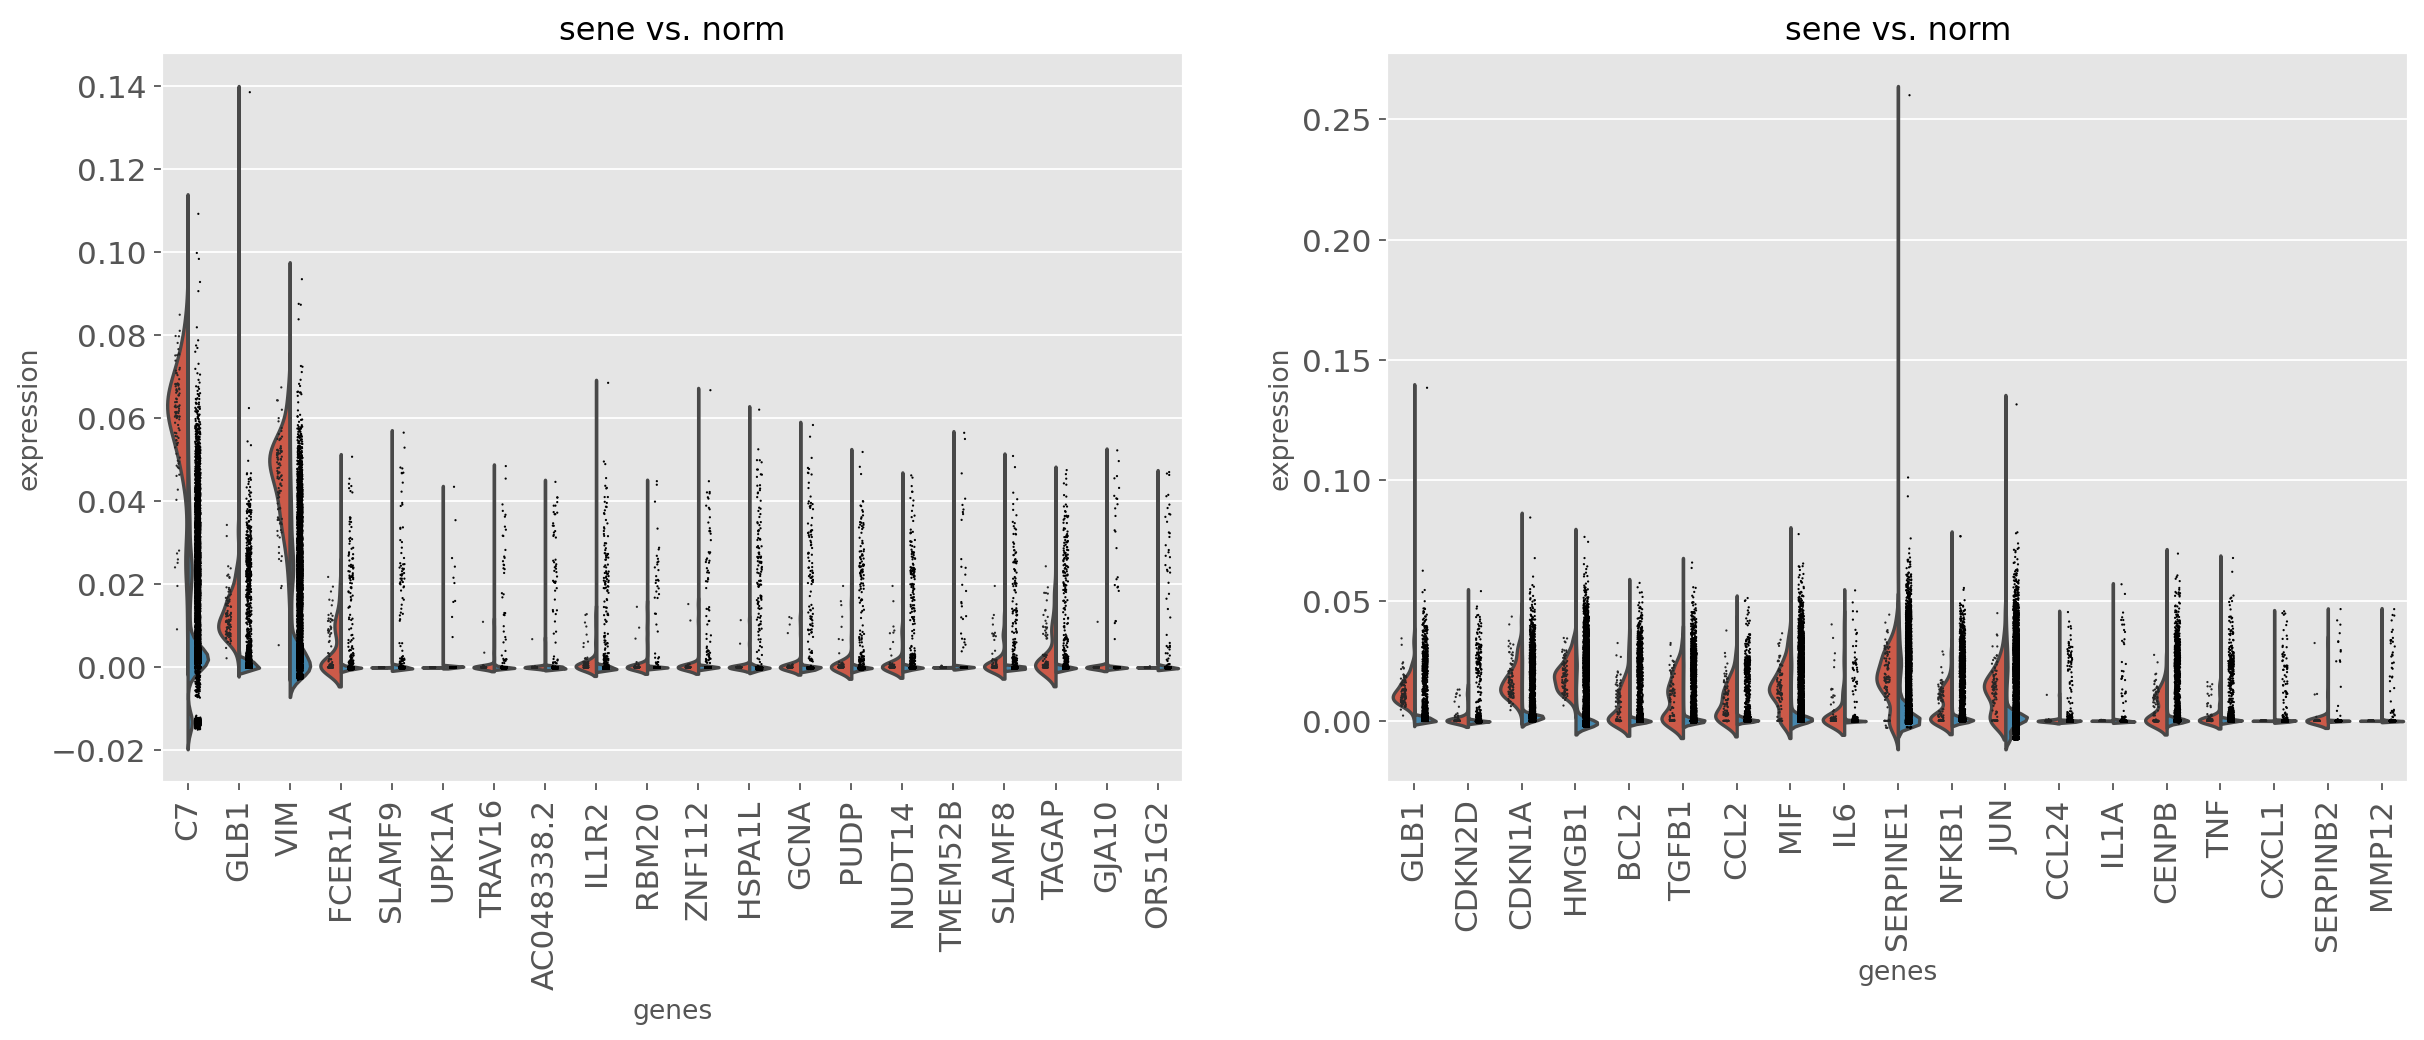

In [644]:
# all senescent cells
genes = ['CDKN1A','GLB1', 'HMGB1']
libraries = ['spaceranger_V12M15_110_A1','spaceranger_V12M15_110_B1','spaceranger_V12F28_066_B1','spaceranger_sample_C','spaceranger_V12F28_066_A1'] #adata_spatial.obs['sample'].cat.categories.tolist()
norm_cluster = ['0', '1', '6']
clusters = [['8'],['8'],['8'],['10'],['10']] # all or the same length of samples
test_label = 'sene'
label_col_name = 'sene_cluster'
de_res_fn = f'{raw_path}/all_sene_VS_normal_spots_wilcoxon.tsv'
de_key = 'rank_gene_all_sene'
all_sene_cells, all_ring_cells, all_norm_cells = \
    DE_for_sene_vs_normal(genes, adata_list, adata_spatial, libraries, clusters, norm_cluster, test_label, label_col_name, de_key, de_res_fn)

de_genes_violin(adata_spatial, test_label, de_key, de_res_fn)

In [511]:
adata_spatial.obs['sene_cluster'].value_counts()

norm     12204
other     9118
ring      6888
sene        96
Name: sene_cluster, dtype: int64

### 3.1.2 Stetosis results

nomral: 20977 
ring_cells: 6888 
sene sells 441 

number of cells in each condition
 norm     12204
other     9136
ring      6888
sene        78
Name: sene_cluster, dtype: int64 

number of sene cells in each cluster
 10    78
0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
11     0
Name: clusters, dtype: int64 

number of up genes: 7900
number of down genes: 1578
up genes overlap with sasp genes: 17
dn genes overlap with sasp genes: 2
up genes overlap with senmyo genes: 71
dn genes overlap with senmyo genes: 8


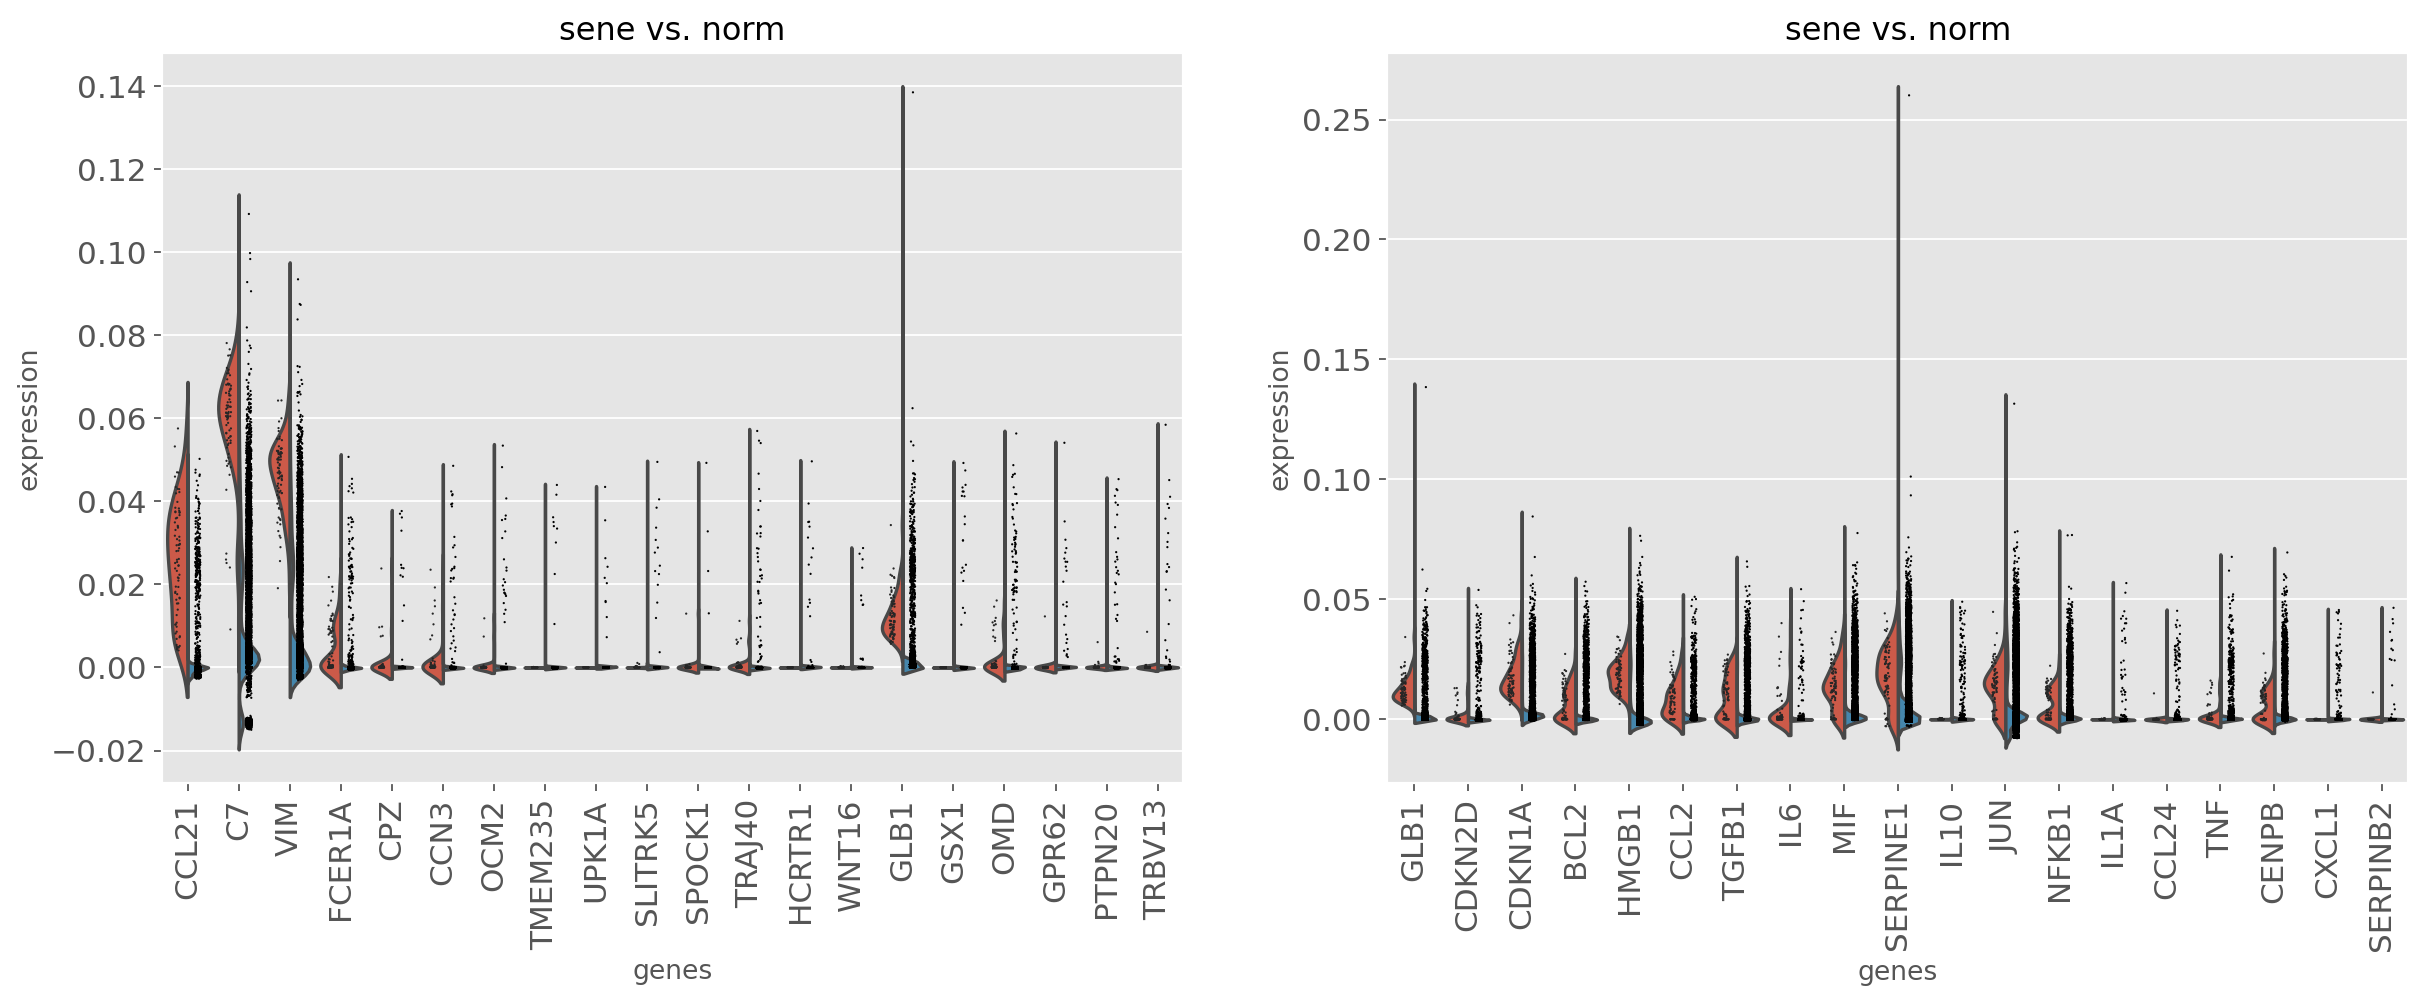

In [646]:
# all senescent cells
genes = ['CDKN1A','GLB1', 'HMGB1']
libraries = ['spaceranger_sample_C', 'spaceranger_V12F28_066_A1']
norm_cluster = ['0', '1', '6']
clusters = [['10'],['10']]
test_label = 'sene'
label_col_name = 'sene_cluster'
de_res_fn = f'{raw_path}/steto_sene_VS_normal_spots_wilcoxon.tsv'
de_key = 'rank_gene_steto_sene'

all_sene_cells, all_ring_cells, all_norm_cells = \
    DE_for_sene_vs_normal(genes, adata_list, adata_spatial, libraries, clusters, norm_cluster, test_label, label_col_name, de_key, de_res_fn)
de_genes_violin(adata_spatial, test_label, de_key, de_res_fn)

### 3.1.3 Fibrosis analysis

nomral: 20977 
ring_cells: 6888 
sene sells 441 

number of cells in each condition
 norm     12204
other     9196
ring      6888
sene        18
Name: sene_cluster, dtype: int64 

number of sene cells in each cluster
 8     18
0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
9      0
10     0
11     0
Name: clusters, dtype: int64 

number of up genes: 3864
number of down genes: 1491
up genes overlap with sasp genes: 10
dn genes overlap with sasp genes: 1
up genes overlap with senmyo genes: 37
dn genes overlap with senmyo genes: 6


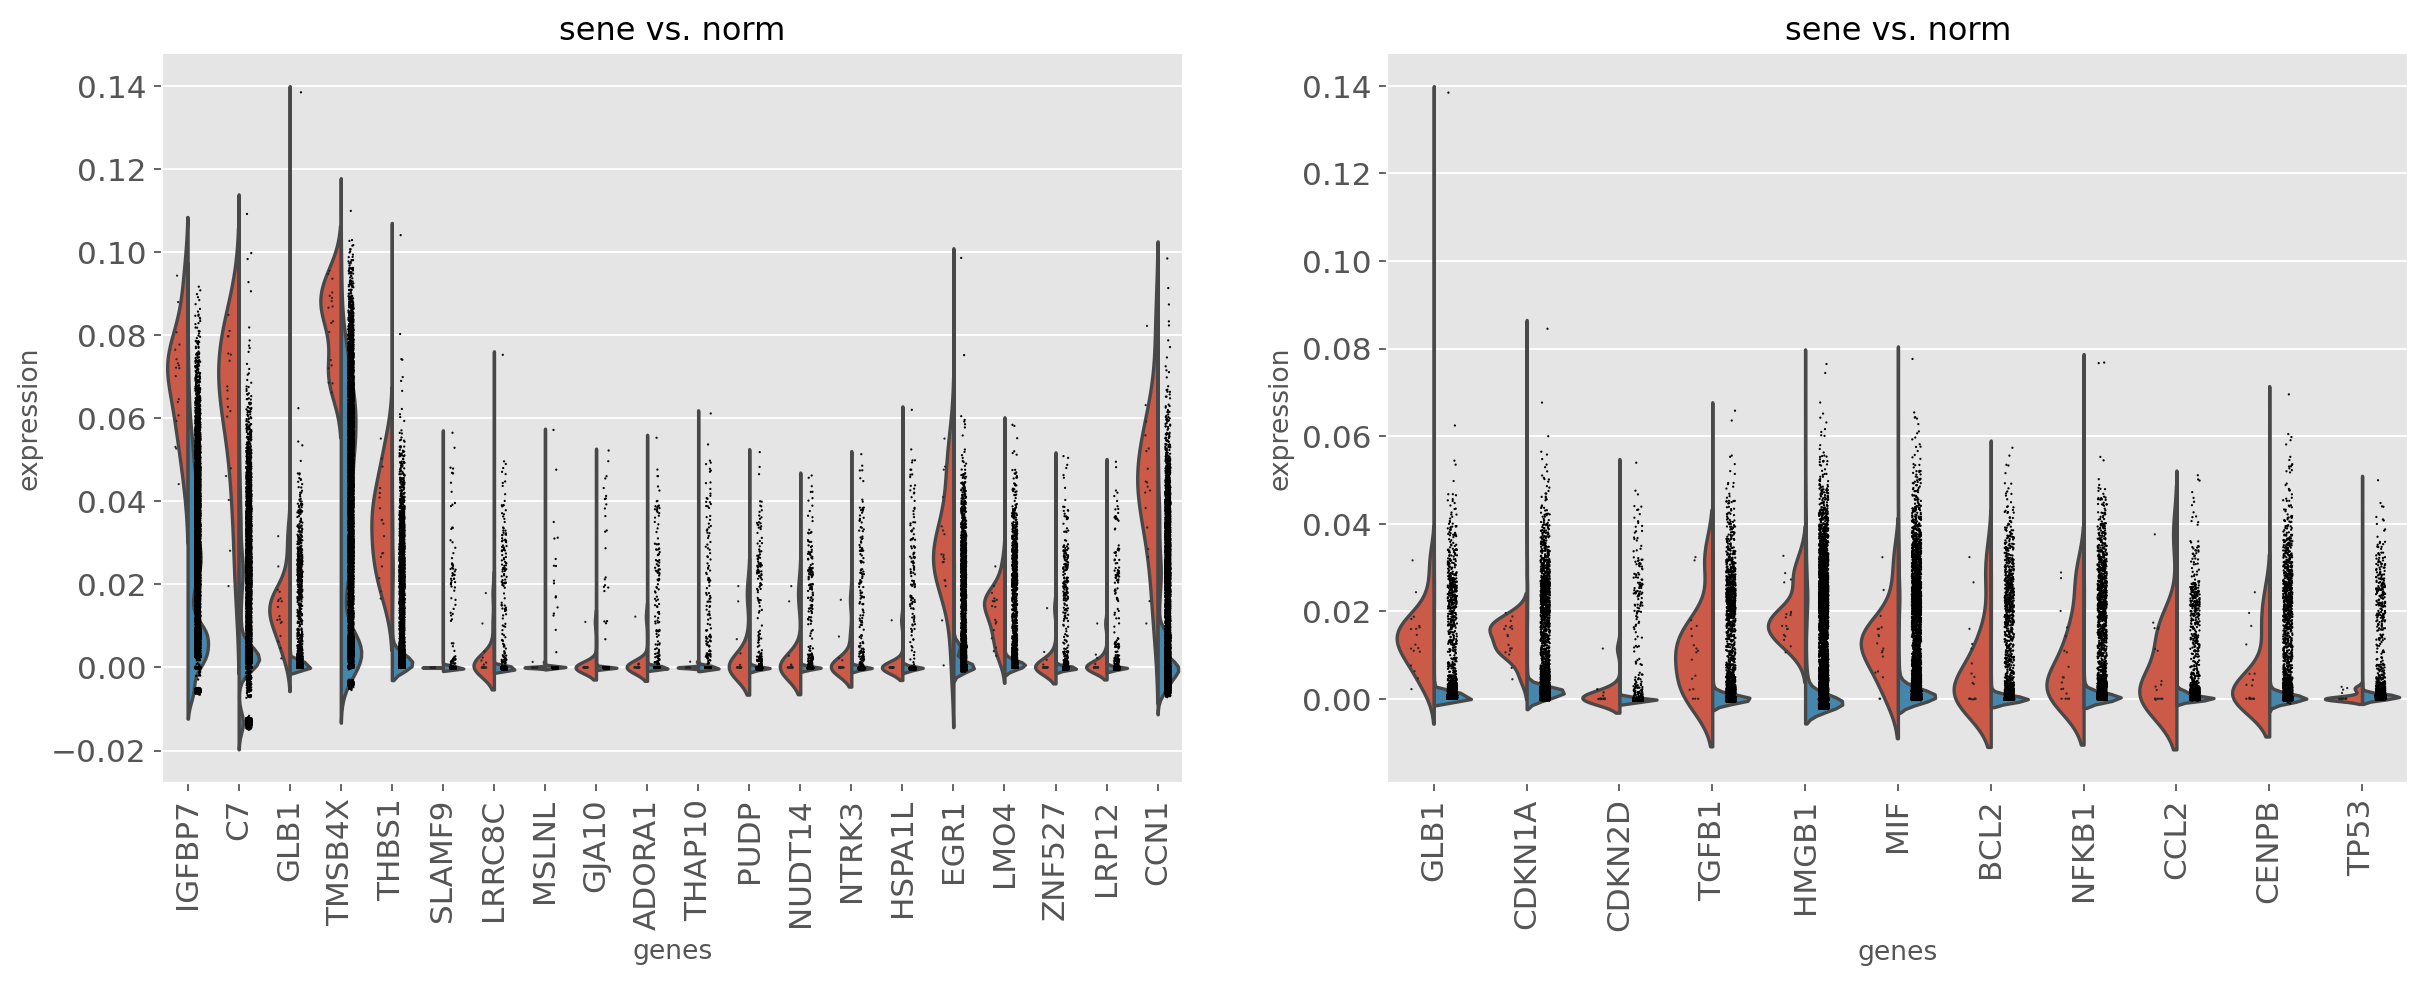

In [649]:
genes = ['CDKN1A','GLB1', 'HMGB1']
libraries = ['spaceranger_V12M15_110_A1','spaceranger_V12M15_110_B1']
clusters = [['8'],['8']]
norm_cluster = ['0', '1', '6']
test_label = 'sene'
label_col_name = 'sene_cluster'
de_res_fn = f'{raw_path}/fibro_sene_VS_normal_spots_wilcoxon.tsv'
de_key = 'rank_gene_fibro_sene'

all_sene_cells, all_ring_cells, all_norm_cells = \
    DE_for_sene_vs_normal(genes, adata_list, adata_spatial, libraries, clusters, norm_cluster, test_label, label_col_name, de_key, de_res_fn)

de_genes_violin(adata_spatial, test_label, de_key ,de_res_fn)

### 3.1.4 DE results overlap

In [650]:
steto_fn = f'{raw_path}/steto_sene_VS_normal_spots_wilcoxon.tsv'
steto_df = pd.read_csv(steto_fn, sep='\t',header=0)
fibro_fn = f'{raw_path}/fibro_sene_VS_normal_spots_wilcoxon.tsv'
fibro_df = pd.read_csv(fibro_fn, sep='\t',header=0)
merge_df = pd.merge(steto_df, fibro_df, how='left',on='sene_names')
merge_df.to_csv(f'{raw_path}/steto_fibro_merge_de_VS_normal_spots_wilcoxon.tsv',sep='\t',index=False)

steto_df, _, _ = vis.get_sig_de_genes(steto_df, 'sene')
fibro_df, _, _ = vis.get_sig_de_genes(fibro_df, 'sene')

Text(0.5, 1.0, 'DE genes overlap between fibrosis and stetosis')

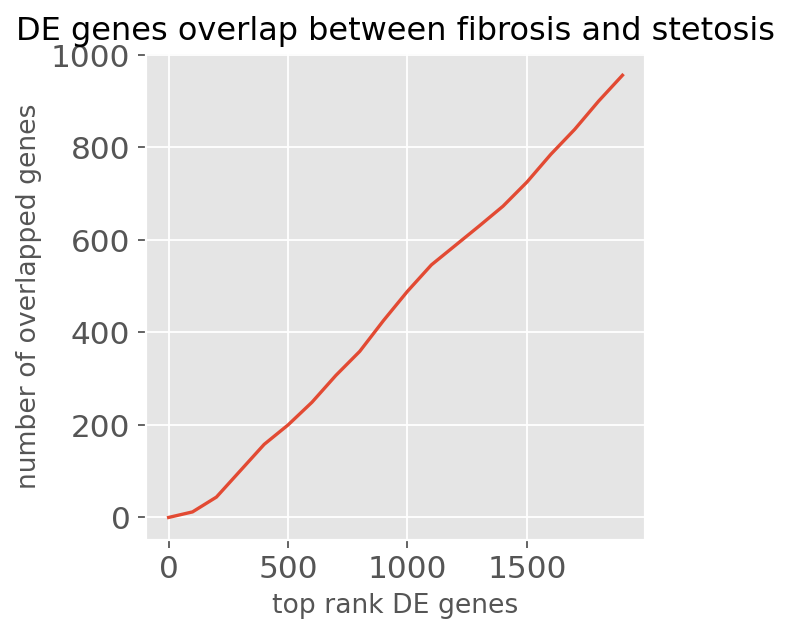

In [523]:
max_n = max(fibro_df.shape[0], steto_df.shape[0])
x = list(range(0,2000,100))
y = []
for i in x:
    inter_sig_genes = list(set(steto_df['sene_names'].tolist()[:i]).intersection(fibro_df['sene_names'].tolist()[:i]))
    y.append(len(inter_sig_genes))
    
fig, ax = plt.subplots()
ax.plot(x,y)
ax.set_xlabel('top rank DE genes')
ax.set_ylabel('number of overlapped genes')
ax.set_title('DE genes overlap between fibrosis and stetosis')

In [517]:
i = 100
top_100 = list(set(steto_df['sene_names'].tolist()[:i]).intersection(fibro_df['sene_names'].tolist()[:i]))

In [518]:
steto_df.query('sene_names in @top_100')

sene_names  sene_logfoldchanges  sene_scores    sene_pvals  \
1            C7             2.672408    14.694747  6.965832e-49   
2           VIM             2.367026    14.445954  2.658495e-47   
3        FCER1A             7.326613    14.413790  4.238013e-47   
23         GLB1             3.126387    14.274273  3.165733e-46   
46        RBM20             4.286447    14.254570  4.198777e-46   
55        AVPR2            -1.355952    14.243197  4.941327e-46   
93       TRAV16             1.536728    14.192452  1.020273e-45   
95   AC048338.2            -1.095710    14.191267  1.037667e-45   
128      SLAMF8             4.238027    14.132978  2.378707e-45   
155      SLAMF9            -2.019721    14.090994  4.314456e-45   
167      ANTXRL            -4.494222    14.069722  5.829810e-45   
172       IL1R2             4.056363    14.059215  6.763304e-45   

     sene_pvals_adj  pts_sene  pts_norm  
1      1.785542e-45  1.000000  0.941085  
2      5.962671e-44  1.000000  0.924943  
3      8.449185e-44  0.692308  0.880039  
23     1.064702e-43  1.000000  0.885120  
46     1.076267e-43  0.525641  0.879056  
55     1.099998e-43  0.512821  0.878974  
93     1.539086e-43  0.512821  0.879220  
95     1.540237e-43  0.512821  0.879548  
128    2.735971e-43  0.576923  0.879794  
155    4.207298e-43  0.512821  0.879712  
167    5.309862e-43  0.512821  0.879138  
172    5.994285e-43  0.551282  0.879712

In [519]:
fibro_df.query('sene_names in @top_100')

sene_names  sene_logfoldchanges  sene_scores    sene_pvals  \
1            C7             2.743382     6.928741  4.246017e-12   
2          GLB1             3.301840     6.888496  5.638520e-12   
5        SLAMF9            -4.289854     6.721032  1.804419e-11   
25        IL1R2             1.113027     6.556844  5.495861e-11   
43       TRAV16             4.321760     6.400410  1.549604e-10   
60   AC048338.2             3.368024     6.342316  2.263372e-10   
109      FCER1A             6.406389     6.196846  5.760597e-10   
114         VIM             2.114260     6.192768  5.911686e-10   
127      SLAMF8             3.914263     6.168333  6.901360e-10   
142       RBM20             5.881788     6.132802  8.634493e-10   
143       AVPR2             2.235219     6.121236  9.285228e-10   
145      ANTXRL            -8.444426     6.116289  9.577960e-10   

     sene_pvals_adj  pts_sene  pts_norm  
1      2.484801e-08  1.000000  0.941085  
2      2.484801e-08  1.000000  0.885120  
5      2.484801e-08  0.444444  0.879712  
25     2.739229e-08  0.444444  0.879712  
43     4.322572e-08  0.500000  0.879220  
60     4.892973e-08  0.444444  0.879548  
109    7.587039e-08  0.611111  0.880039  
114    7.587039e-08  1.000000  0.924943  
127    8.146783e-08  0.500000  0.879794  
142    9.113453e-08  0.500000  0.879056  
143    9.742973e-08  0.444444  0.878974  
145    9.907967e-08  0.444444  0.879138

### 3.1.5 Volcano plot

In [74]:
plot_genes = de_df[(de_df['sene_logfoldchanges'] > 1) & (de_df['sene_pvals_adj'] < 0.05)]['sene_names'].tolist() + \
    de_df[(de_df['sene_logfoldchanges'] < -1) & (de_df['sene_pvals_adj'] < 0.05)]['sene_names'].tolist()
plot_de_df = de_df.query('sene_logfoldchanges == sene_logfoldchanges')
# plot_de_df = plot_de_df['sene_logfoldchanges'].astype(float)

In [75]:
plot_genes = plot_genes[:5]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


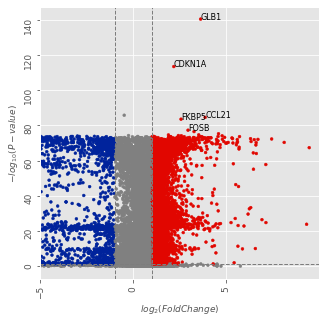

In [76]:
logfc = 'sene_logfoldchanges'
pv = 'sene_pvals_adj'
title = 'senecent_cells_vs_normal_cells'
gene_col = 'sene_names'
visuz.GeneExpression.volcano(df=plot_de_df, lfc=logfc, pv=pv,
            color=("#E10600FF","grey","#00239CFF"),figname=title,
            sign_line=True,geneid=gene_col,genenames=tuple(plot_genes),gfont=8,gstyle=1,show=True,
            xlm=(-5,10,5))

Text(0.5, 0.98, 'sample B GLB1 expression')

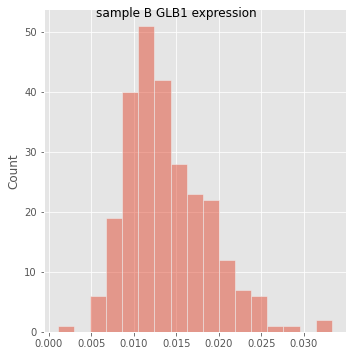

In [71]:
g = 'GLB1'
test = adata_spatial[adata_spatial.obs['sene_cluster'] == 'sene']
ax = sns.displot(test[test[:,g].X>0][:,g].X.toarray(),kde=False,legend=False)
ax.fig.suptitle(f'sample B {g} expression')

## 3.2 Run DE analysis for fibrotic clusters with normal clusters

In [605]:
def add_fibro_clusters(clust, normal_clusts, fibro_clusts):
    if clust in normal_clusts:
        return 'norm'
    elif clust in fibro_clusts:
        return 'fibro'
    else:
        return 'other'

normal_clusts = ['0','1','6']
fibro_clusts = ['8','10']
label_col_name = 'fibro_cluster'
adata_spatial.obs['fibro_cluster'] = adata_spatial.obs['clusters'].map(lambda x: add_fibro_clusters(x, normal_clusts, fibro_clusts))

In [634]:
test_label = 'fibro'
key = 'rank_genes_fibro_clust_vs_norm'
sc.tl.rank_genes_groups(adata_spatial, groupby='fibro_cluster', groups=['norm','fibro'], reference='norm', pts=True, key_added=key)
de_df = vis.format_rank_gene2df(adata_spatial, key, test_label)
fibro_vs_norm_fn = f'{raw_path}/fibro_vs_norm.tsv'
de_df.to_csv(fibro_vs_norm_fn, sep='\t',index=False)

number of up genes: 7534
number of down genes: 816
up genes overlap with sasp genes: 19
dn genes overlap with sasp genes: 0
up genes overlap with senmyo genes: 68
dn genes overlap with senmyo genes: 6


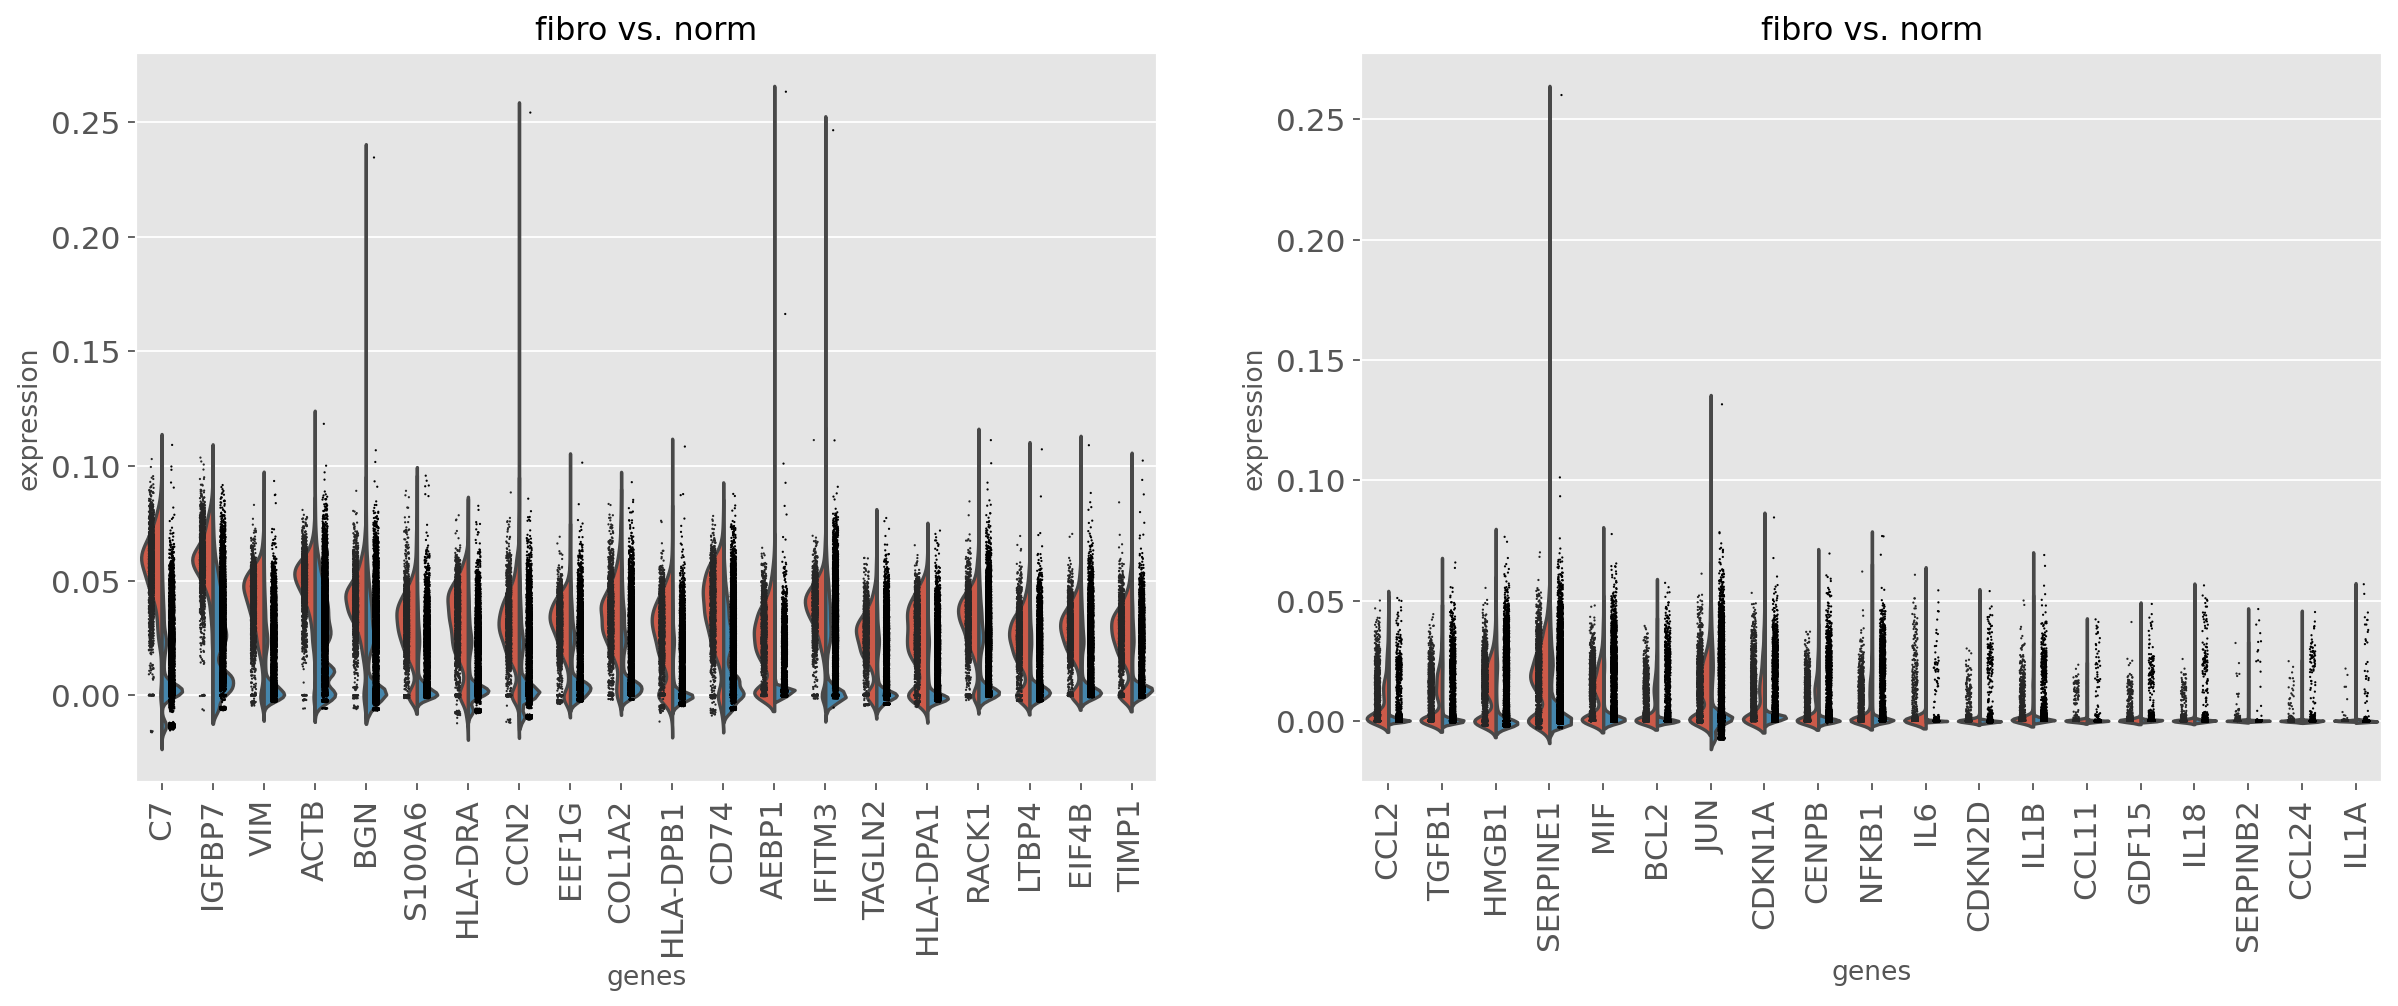

In [651]:
test_label = 'fibro'
de_key = 'rank_genes_fibro_clust_vs_norm'
de_res_fn = f'{raw_path}/fibro_vs_norm.tsv'
de_genes_violin(adata_spatial, test_label, de_key, de_res_fn)